In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/adult-census-income/adult.csv


In [2]:
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)


In [3]:
df = pd.read_csv('/kaggle/input/adult-census-income/adult.csv')
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [4]:
df.shape

(32561, 15)

In [5]:
df.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education.num',
       'marital.status', 'occupation', 'relationship', 'race', 'sex',
       'capital.gain', 'capital.loss', 'hours.per.week', 'native.country',
       'income'],
      dtype='object')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education.num   32561 non-null  int64 
 5   marital.status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital.gain    32561 non-null  int64 
 11  capital.loss    32561 non-null  int64 
 12  hours.per.week  32561 non-null  int64 
 13  native.country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [7]:
df.dtypes.value_counts()

object    9
int64     6
Name: count, dtype: int64

In [8]:
df.describe()

,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [9]:
df.nunique()

age                  73
workclass             9
fnlwgt            21648
education            16
education.num        16
marital.status        7
occupation           15
relationship          6
race                  5
sex                   2
capital.gain        119
capital.loss         92
hours.per.week       94
native.country       42
income                2
dtype: int64

In [10]:
if df.isnull().sum().sum() > 0:
    import missingno as msno
    msno.matrix(df)
    msno.heatmap(df)
else:
    print("No missing values — skipping missingno plots.")


No missing values — skipping missingno plots.


# EDA

In [11]:
df['income'].describe()

count     32561
unique        2
top       <=50K
freq      24720
Name: income, dtype: object

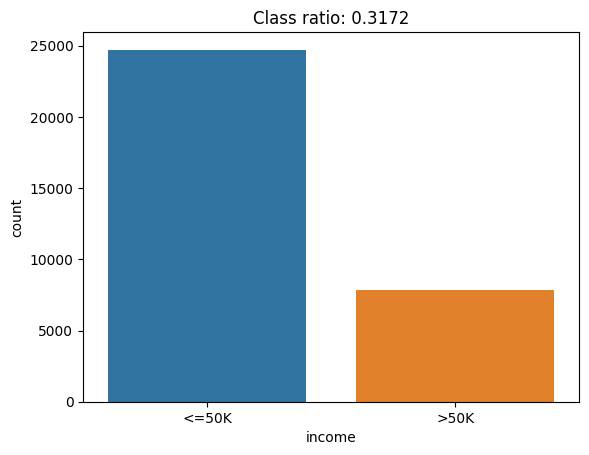

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

target_counts = df['income'].value_counts()
plt.Figure(figsize = (10, 6))
sns.countplot(x=df['income'], data = df)
plt.title(f"Class ratio: {target_counts[1]/target_counts[0]:.4f}")
plt.show()

## Numerical Distribution and Outlier Check

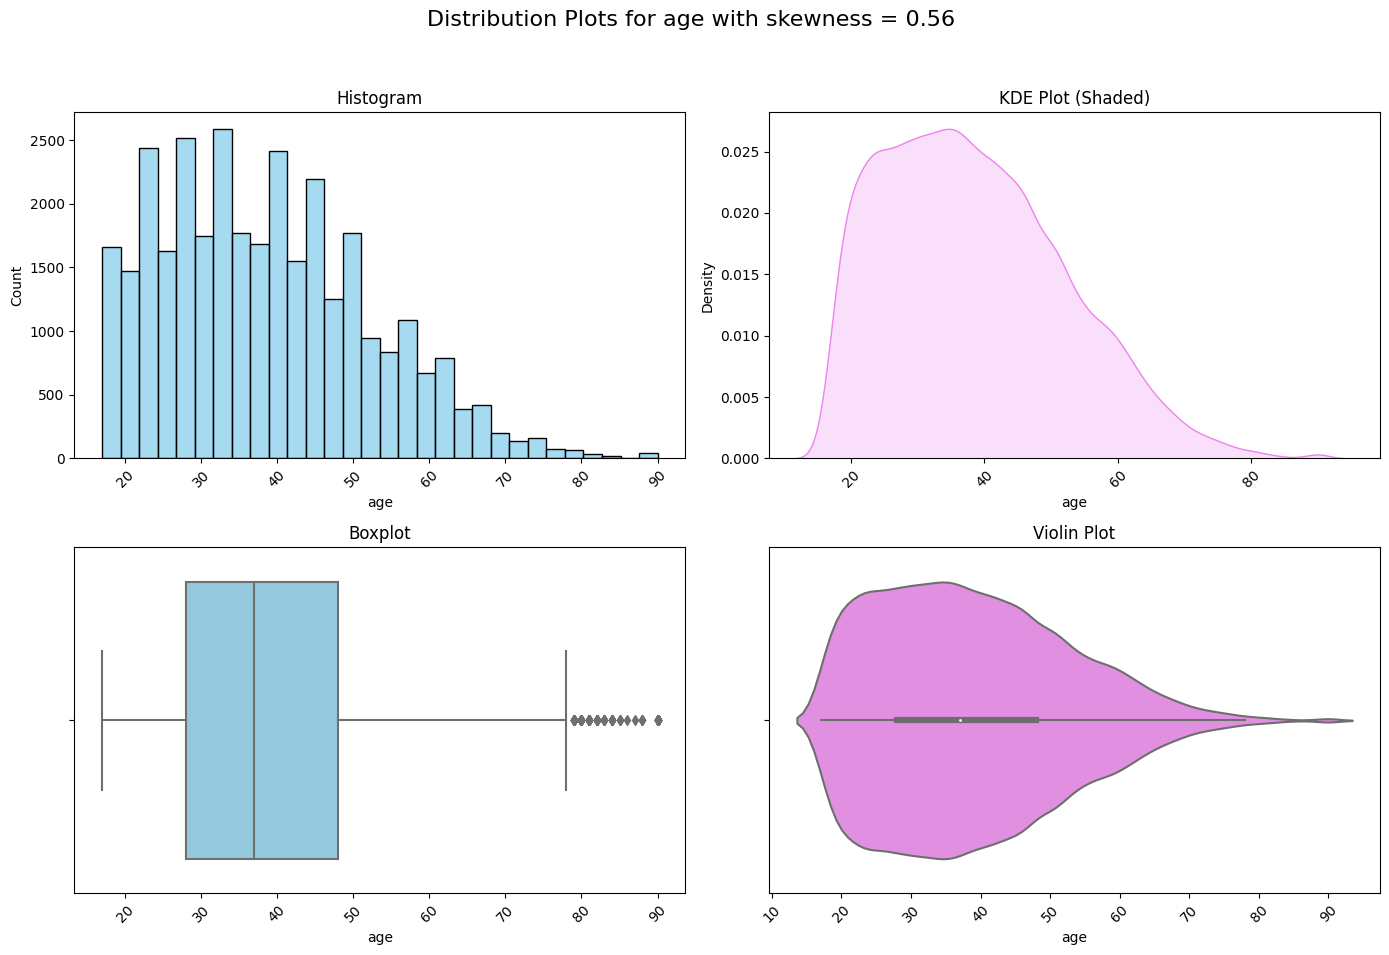

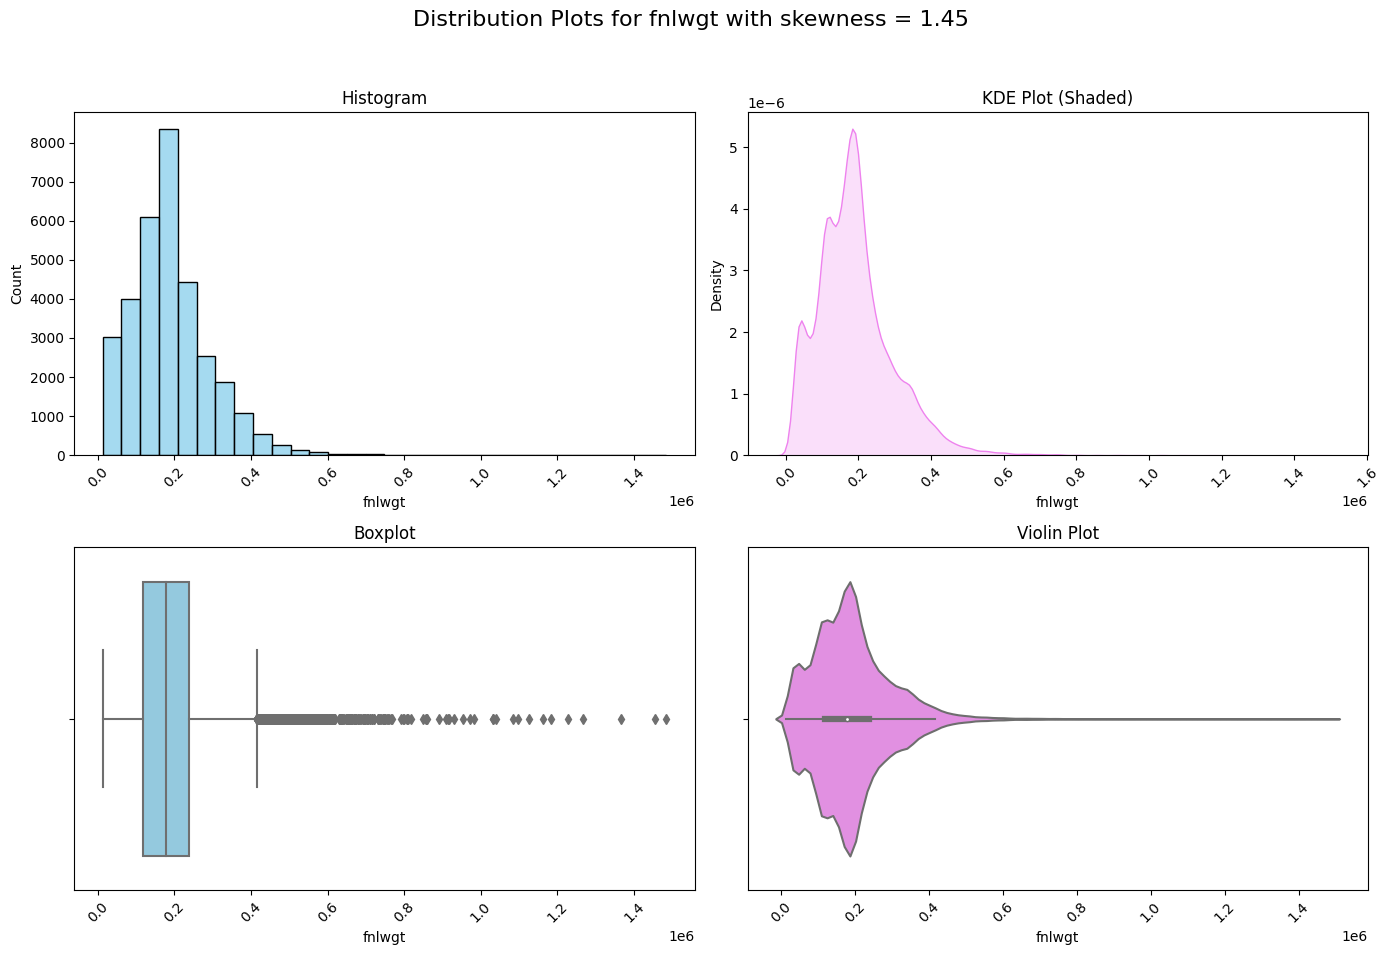

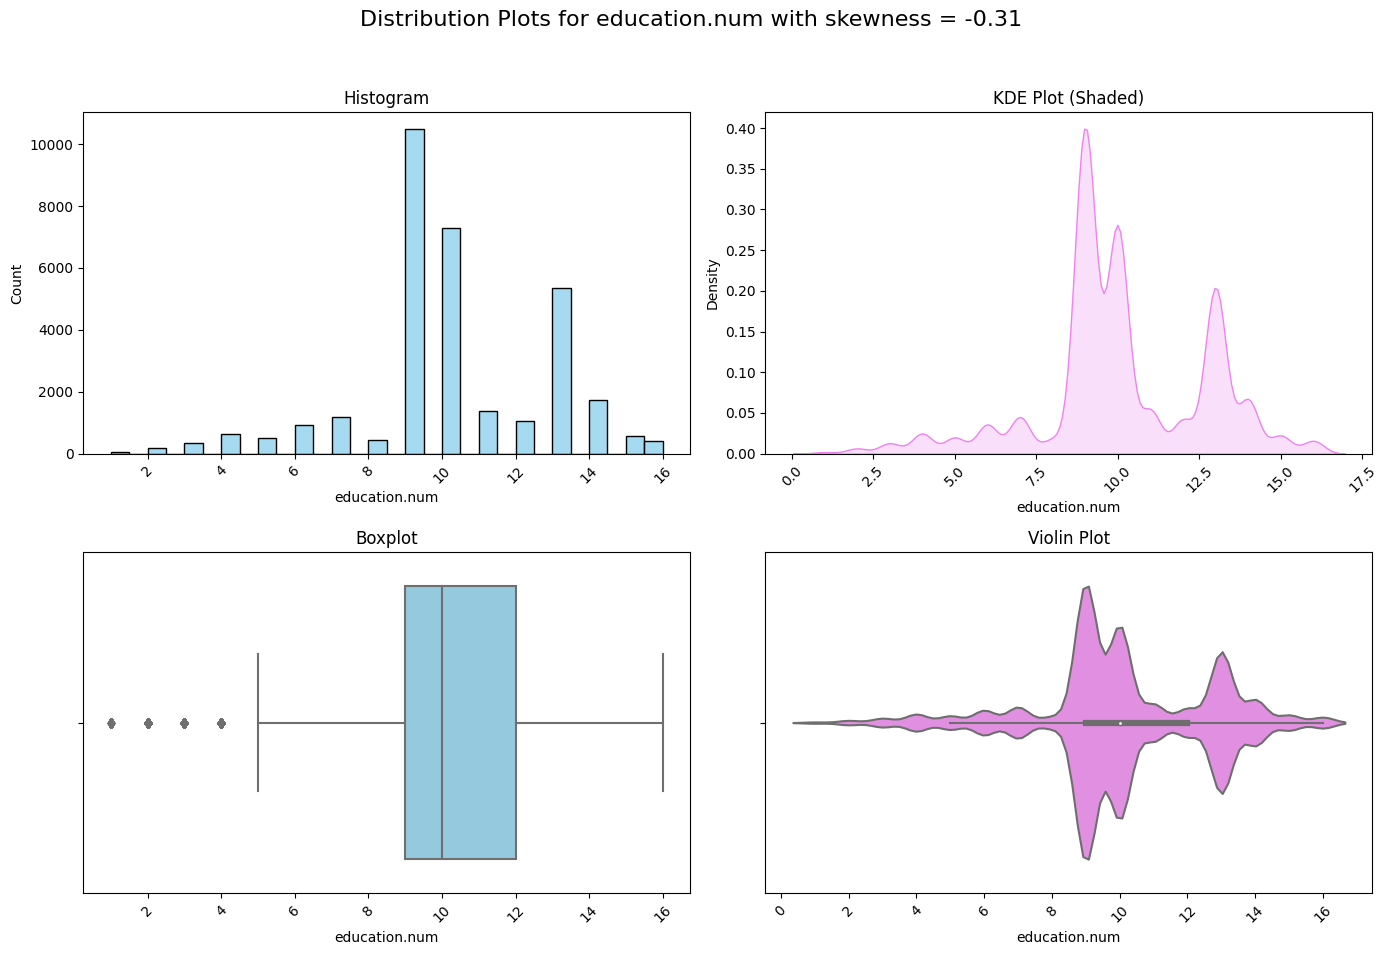

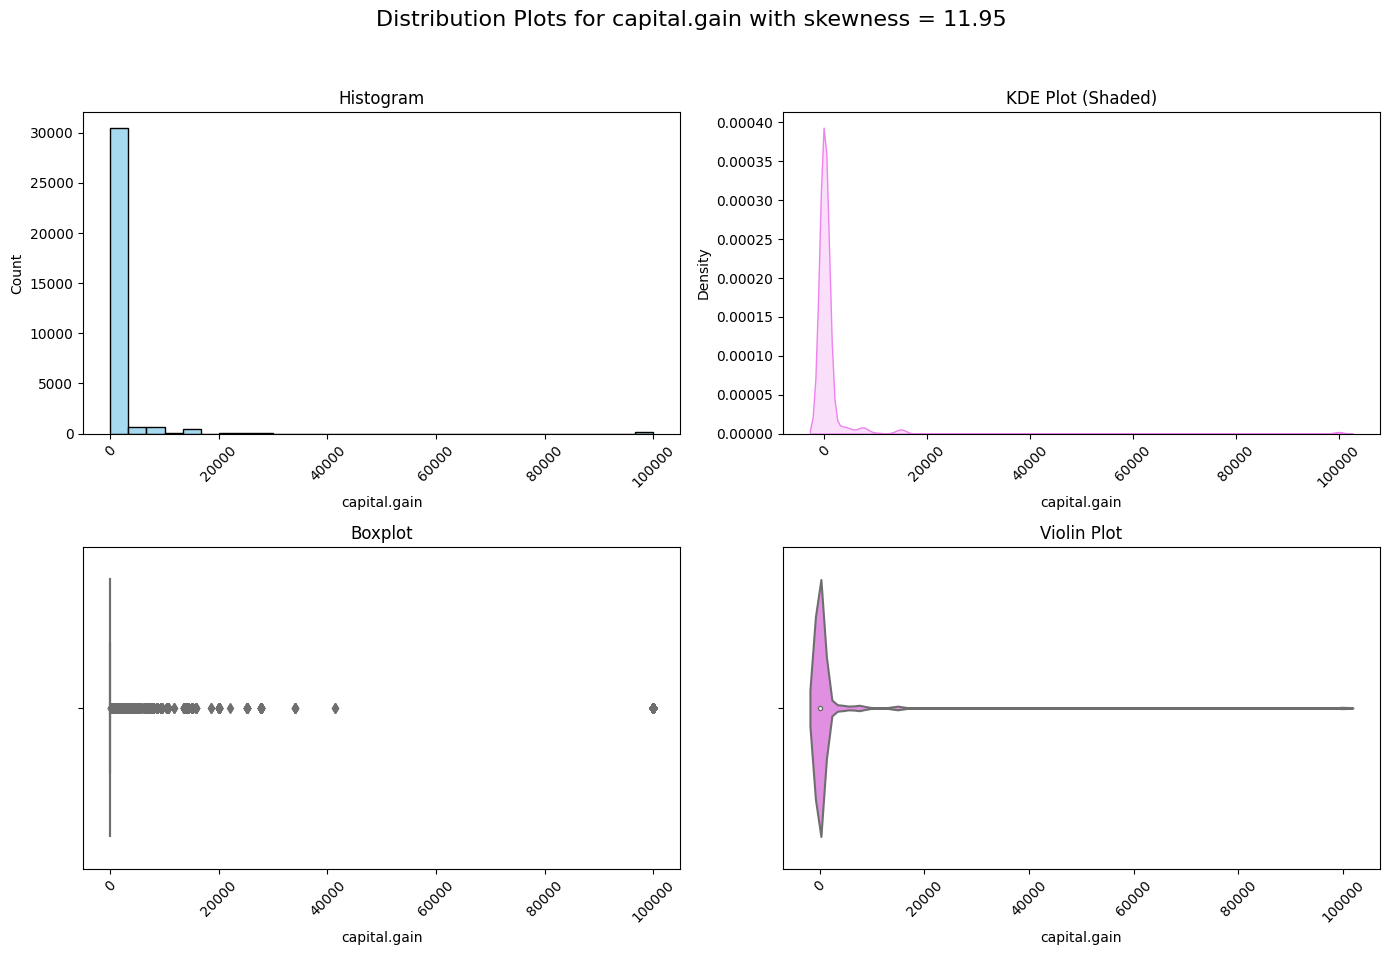

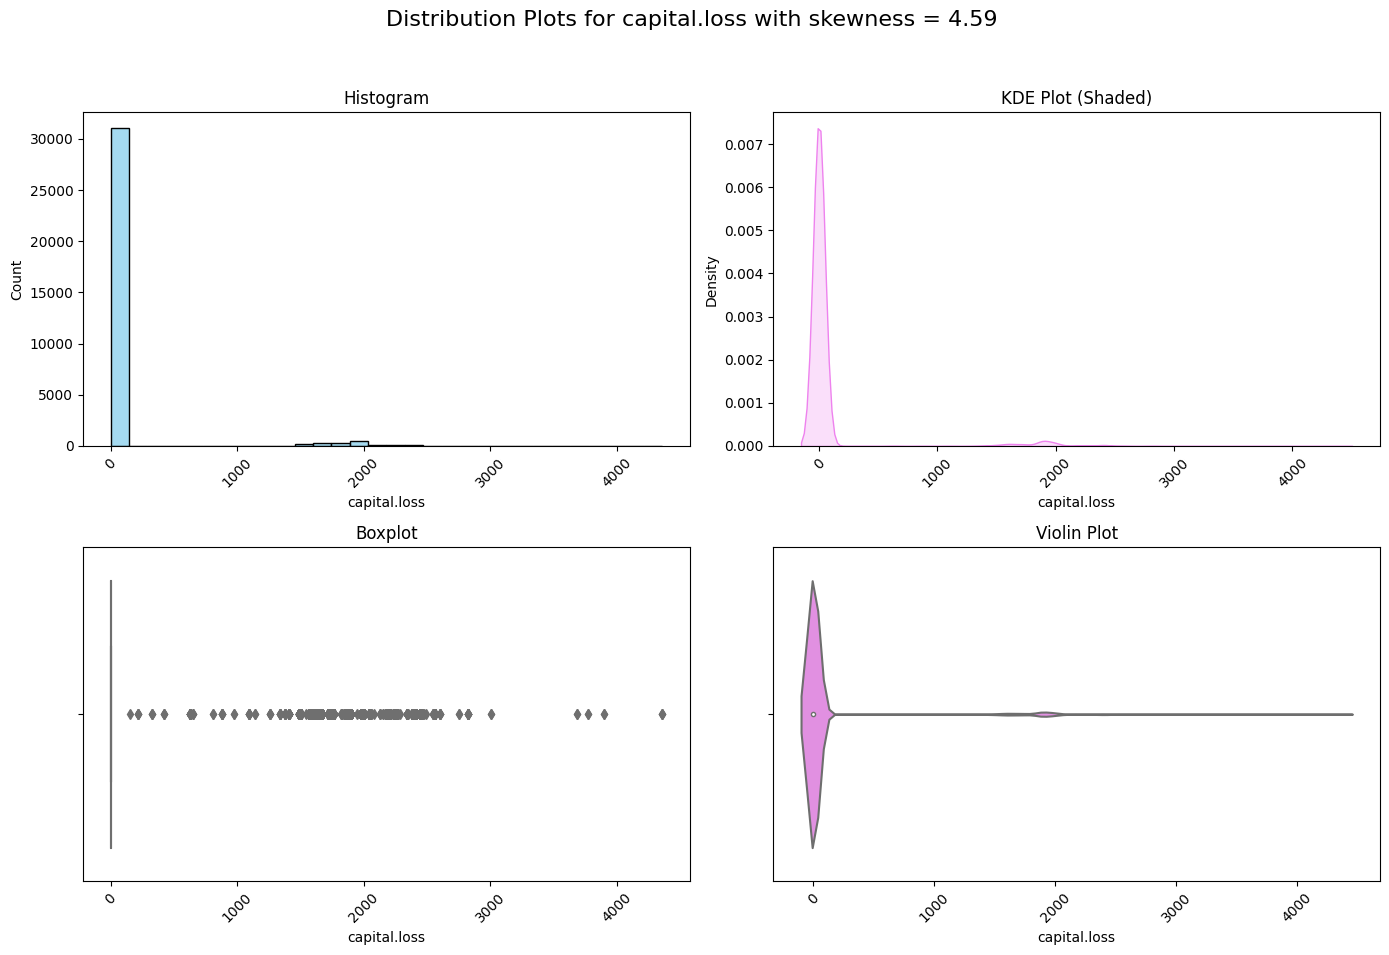

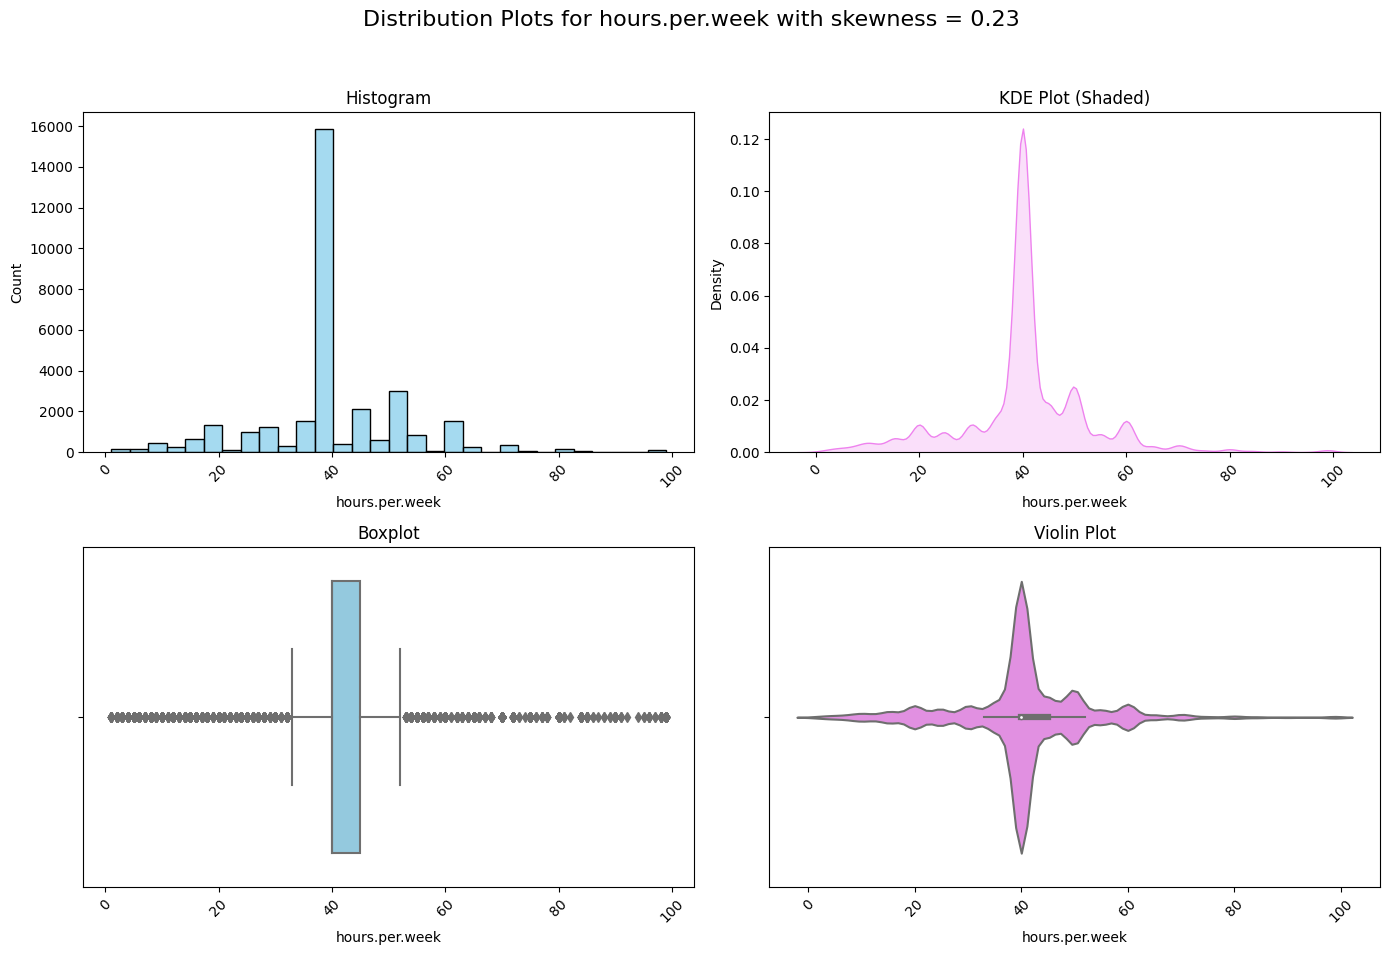

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

num_cols = df.select_dtypes(include=['int64', 'float64']).columns

for col in num_cols:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(f"Distribution Plots for {col} with skewness = {df[col].skew():.2f} ", fontsize=16)

    # Histogram
    sns.histplot(df[col], bins=30, kde=False, ax=axes[0, 0], color='skyblue')
    axes[0, 0].set_title('Histogram')
    axes[0, 0].tick_params(axis='x', rotation=45)

    # KDE plot with fill
    sns.kdeplot(df[col], fill=True, ax=axes[0, 1], color='violet')
    axes[0, 1].set_title('KDE Plot (Shaded)')
    axes[0, 1].tick_params(axis='x', rotation=45)

    # Boxplot
    sns.boxplot(x=df[col], ax=axes[1, 0], color='skyblue')
    axes[1, 0].set_title('Boxplot')
    axes[1, 0].tick_params(axis='x', rotation=45)

    # Violin plot
    sns.violinplot(x=df[col], ax=axes[1, 1], color='violet')
    axes[1, 1].set_title('Violin Plot')
    axes[1, 1].tick_params(axis='x', rotation=45)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
    plt.show()


## Categorical Frequency and Relation with Target

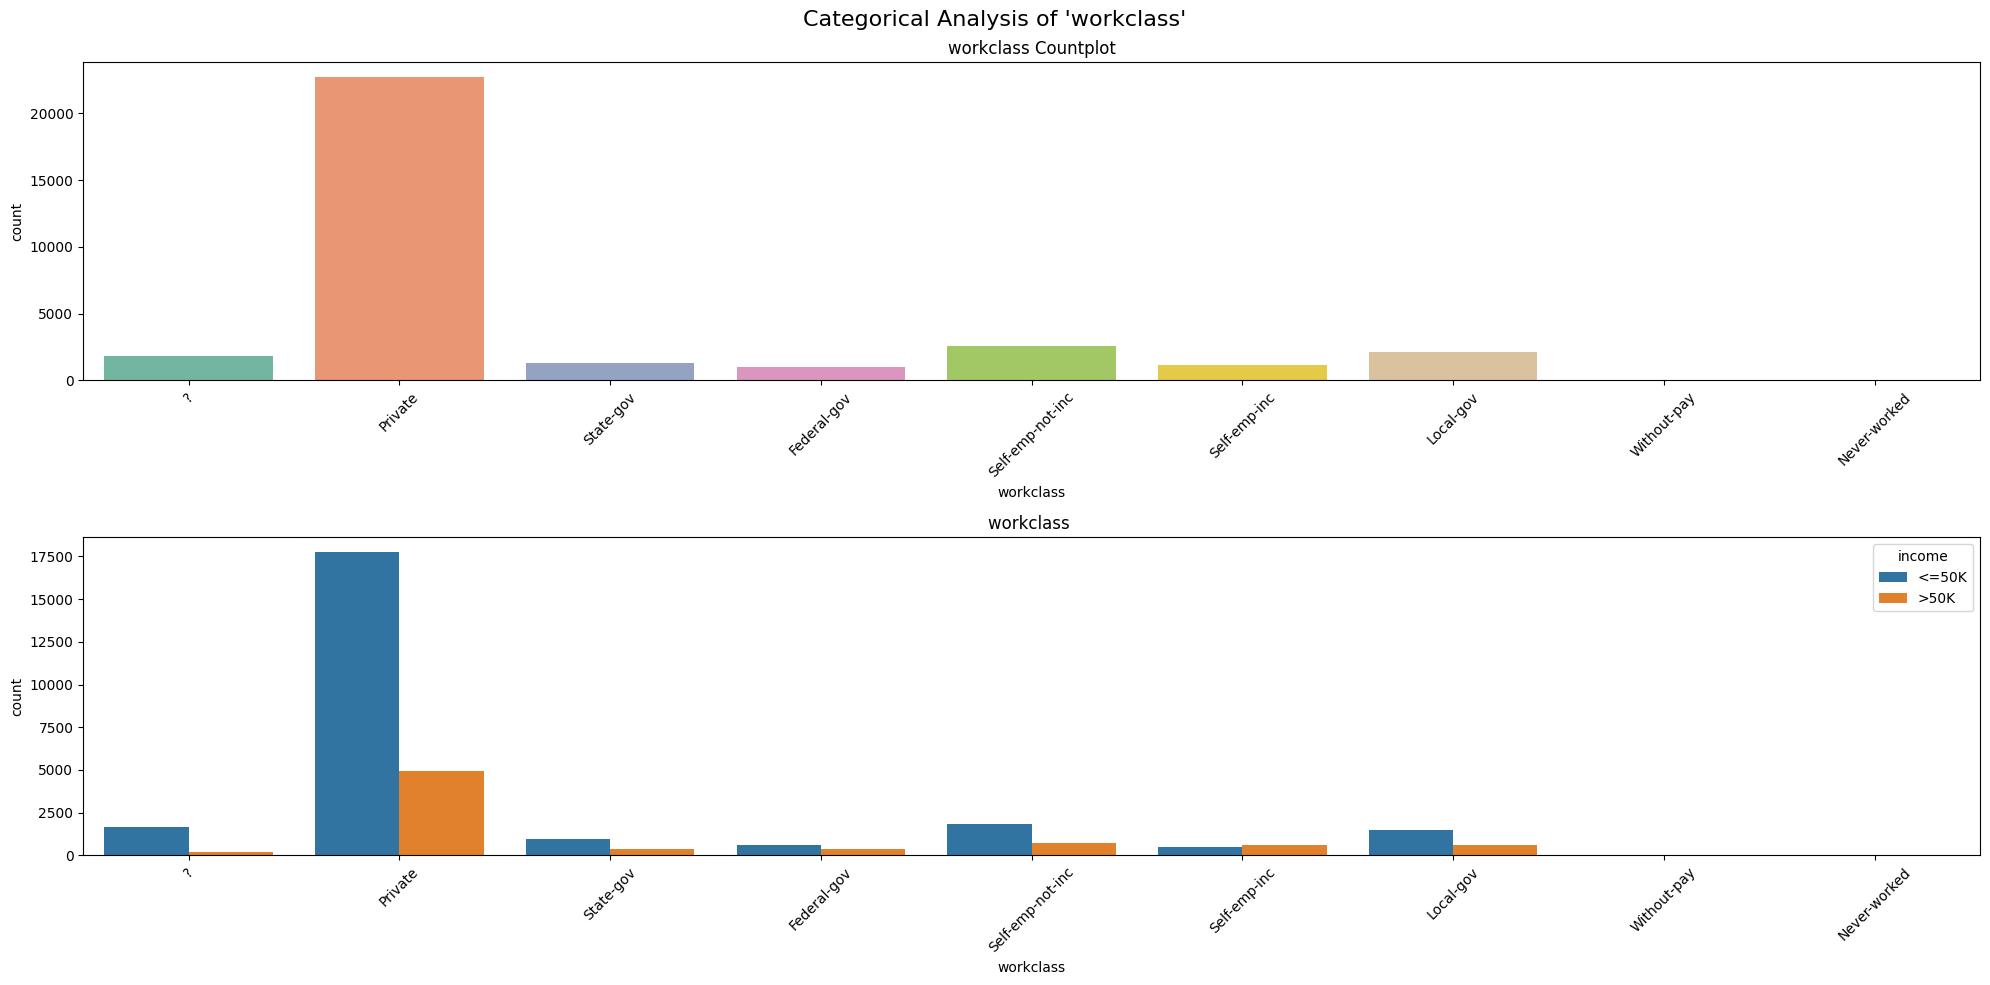

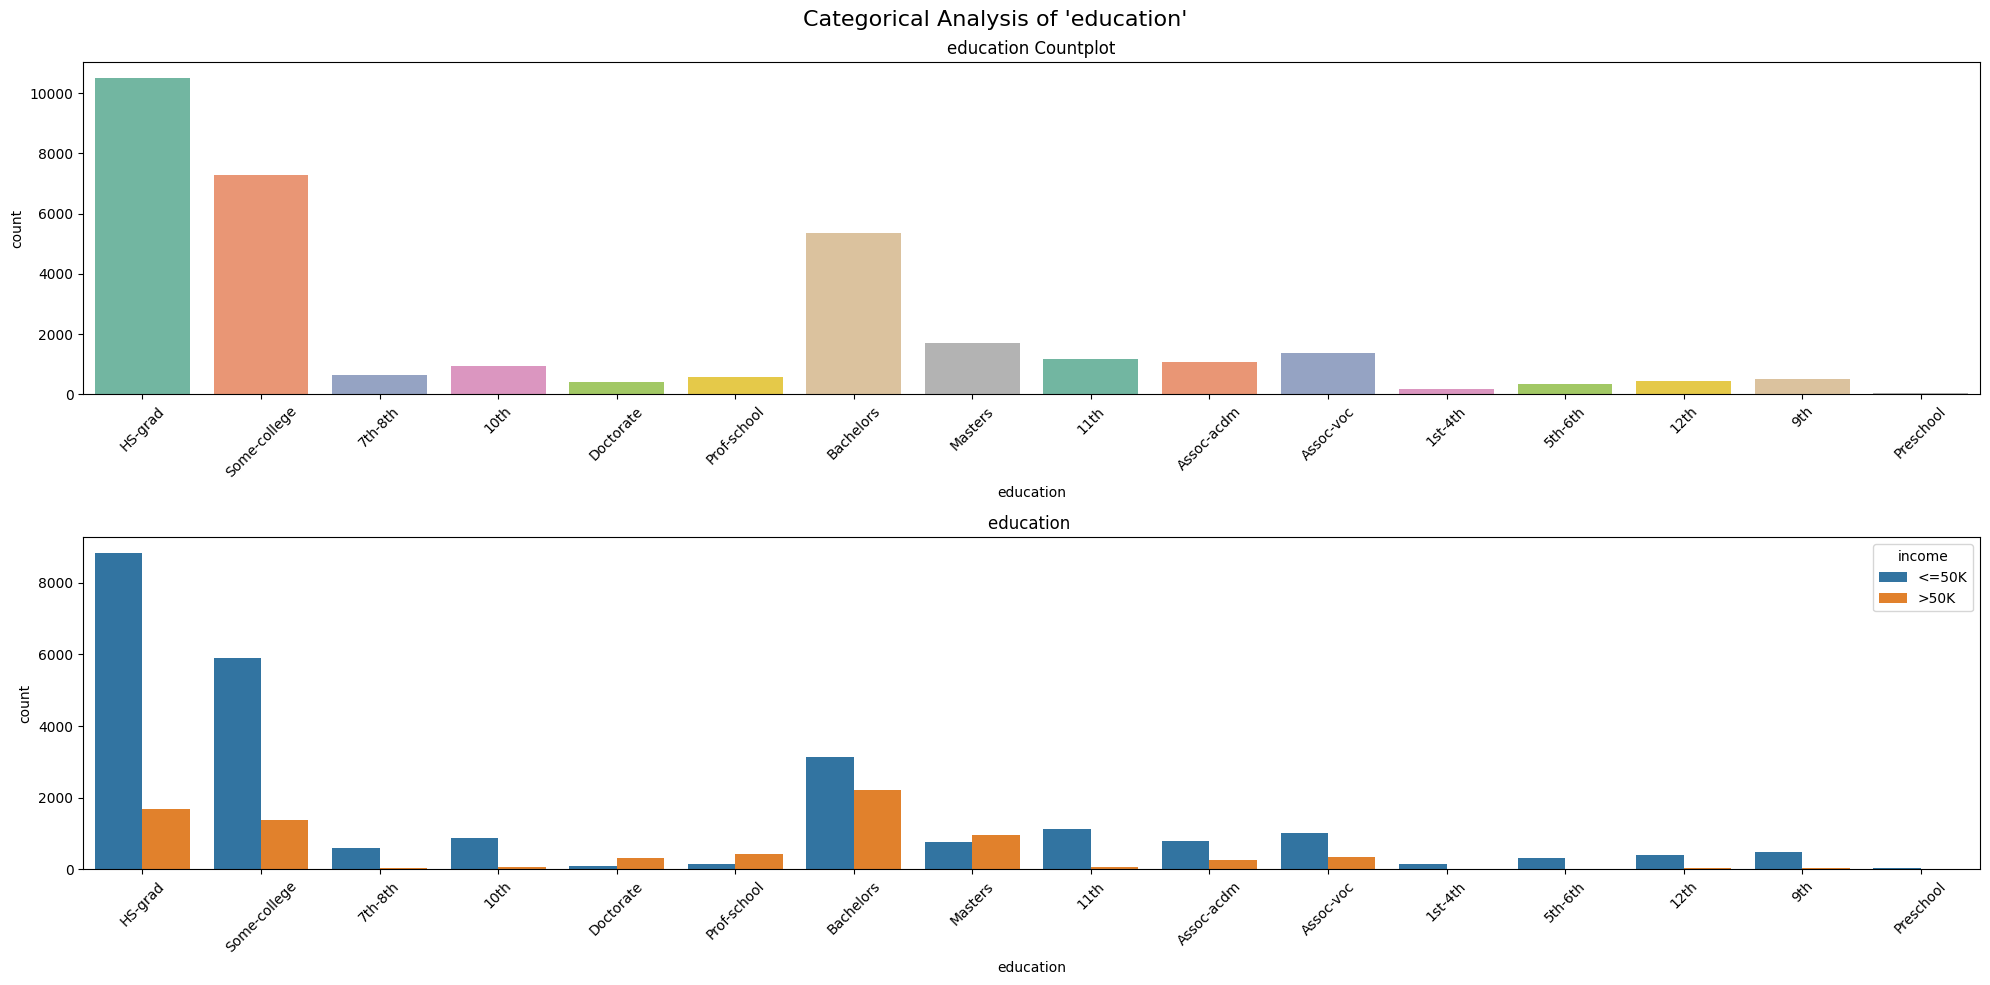

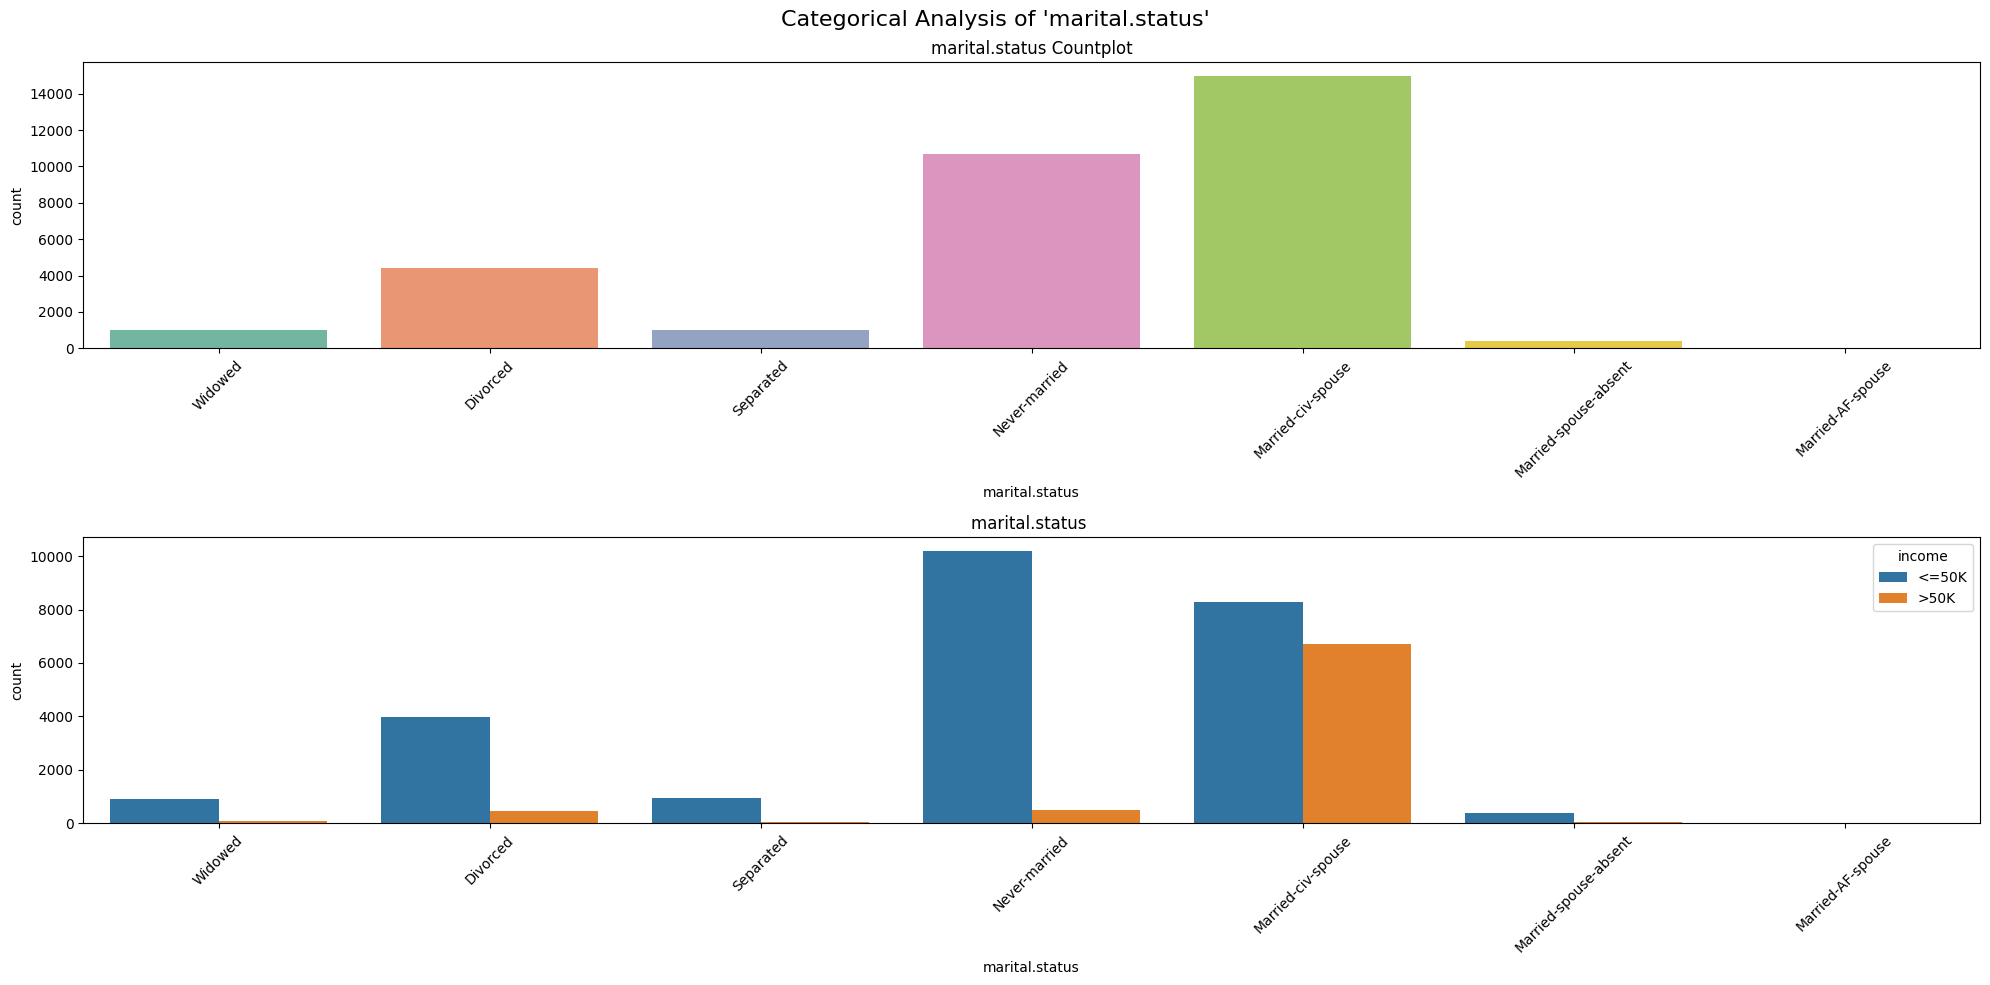

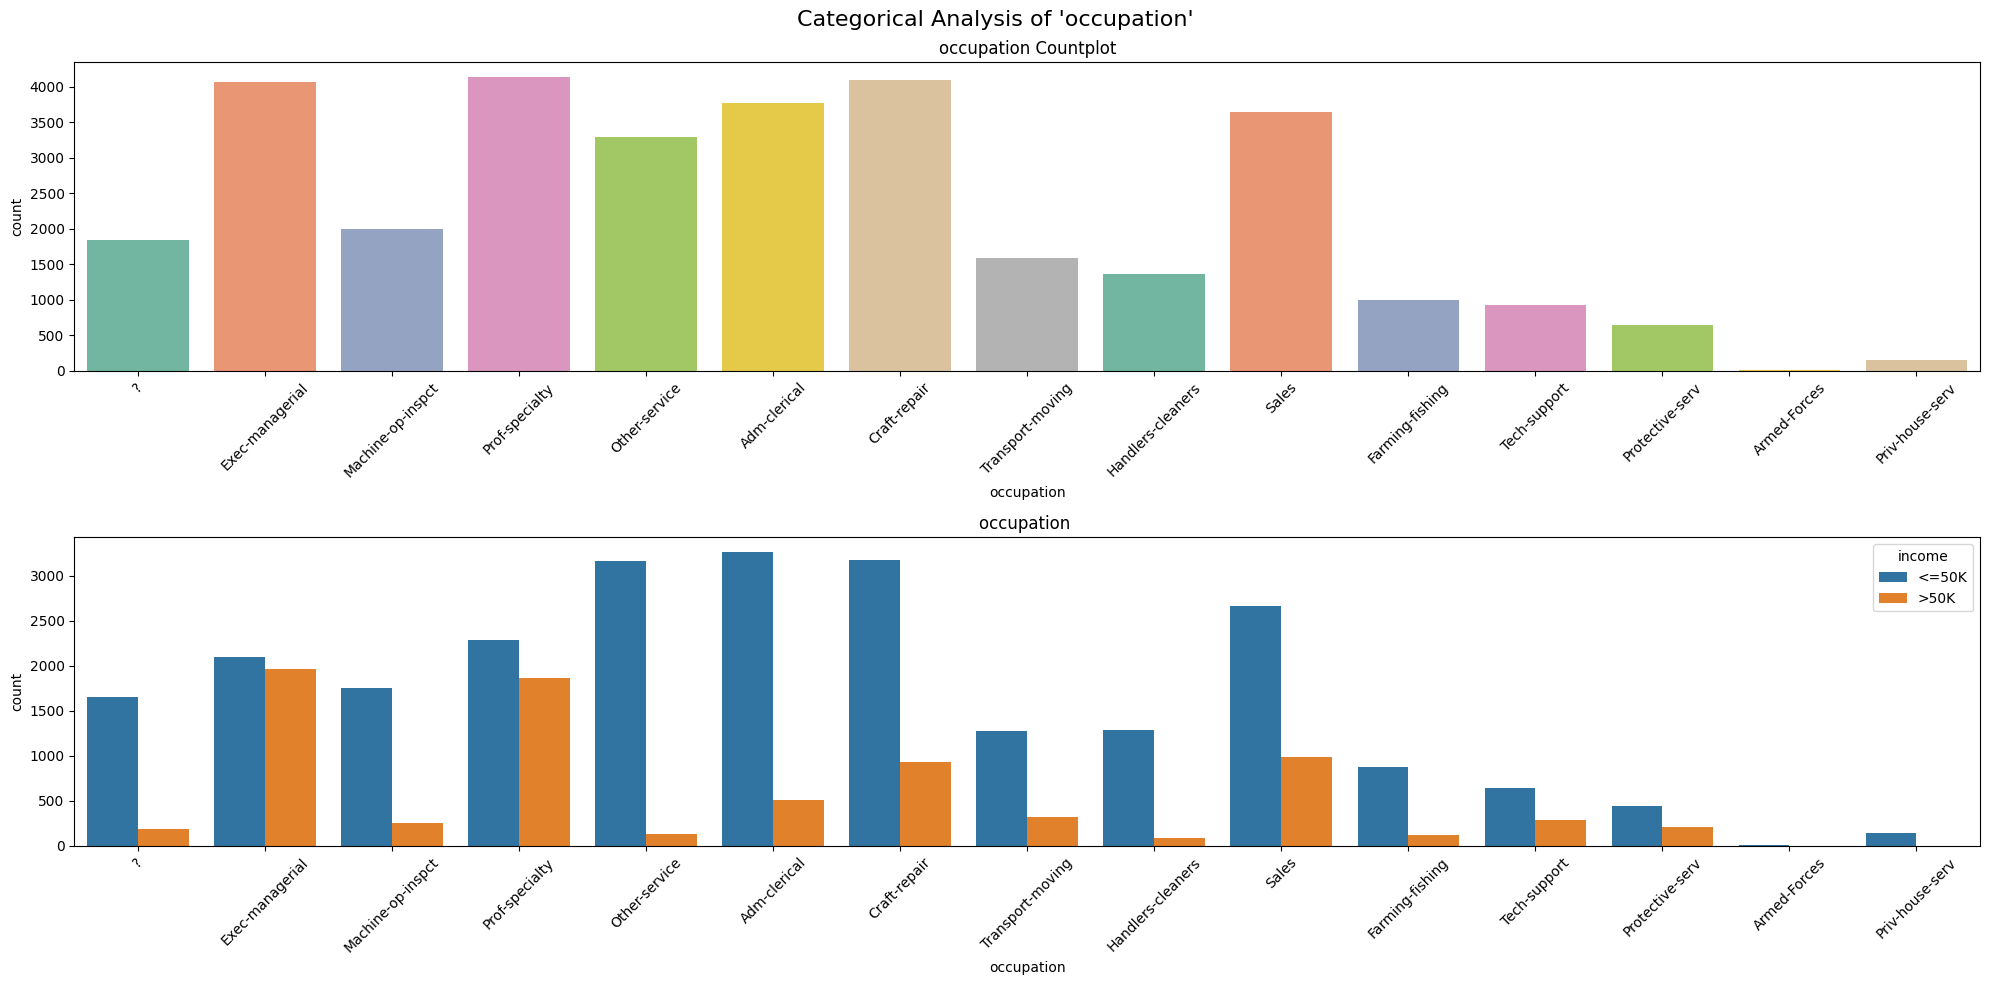

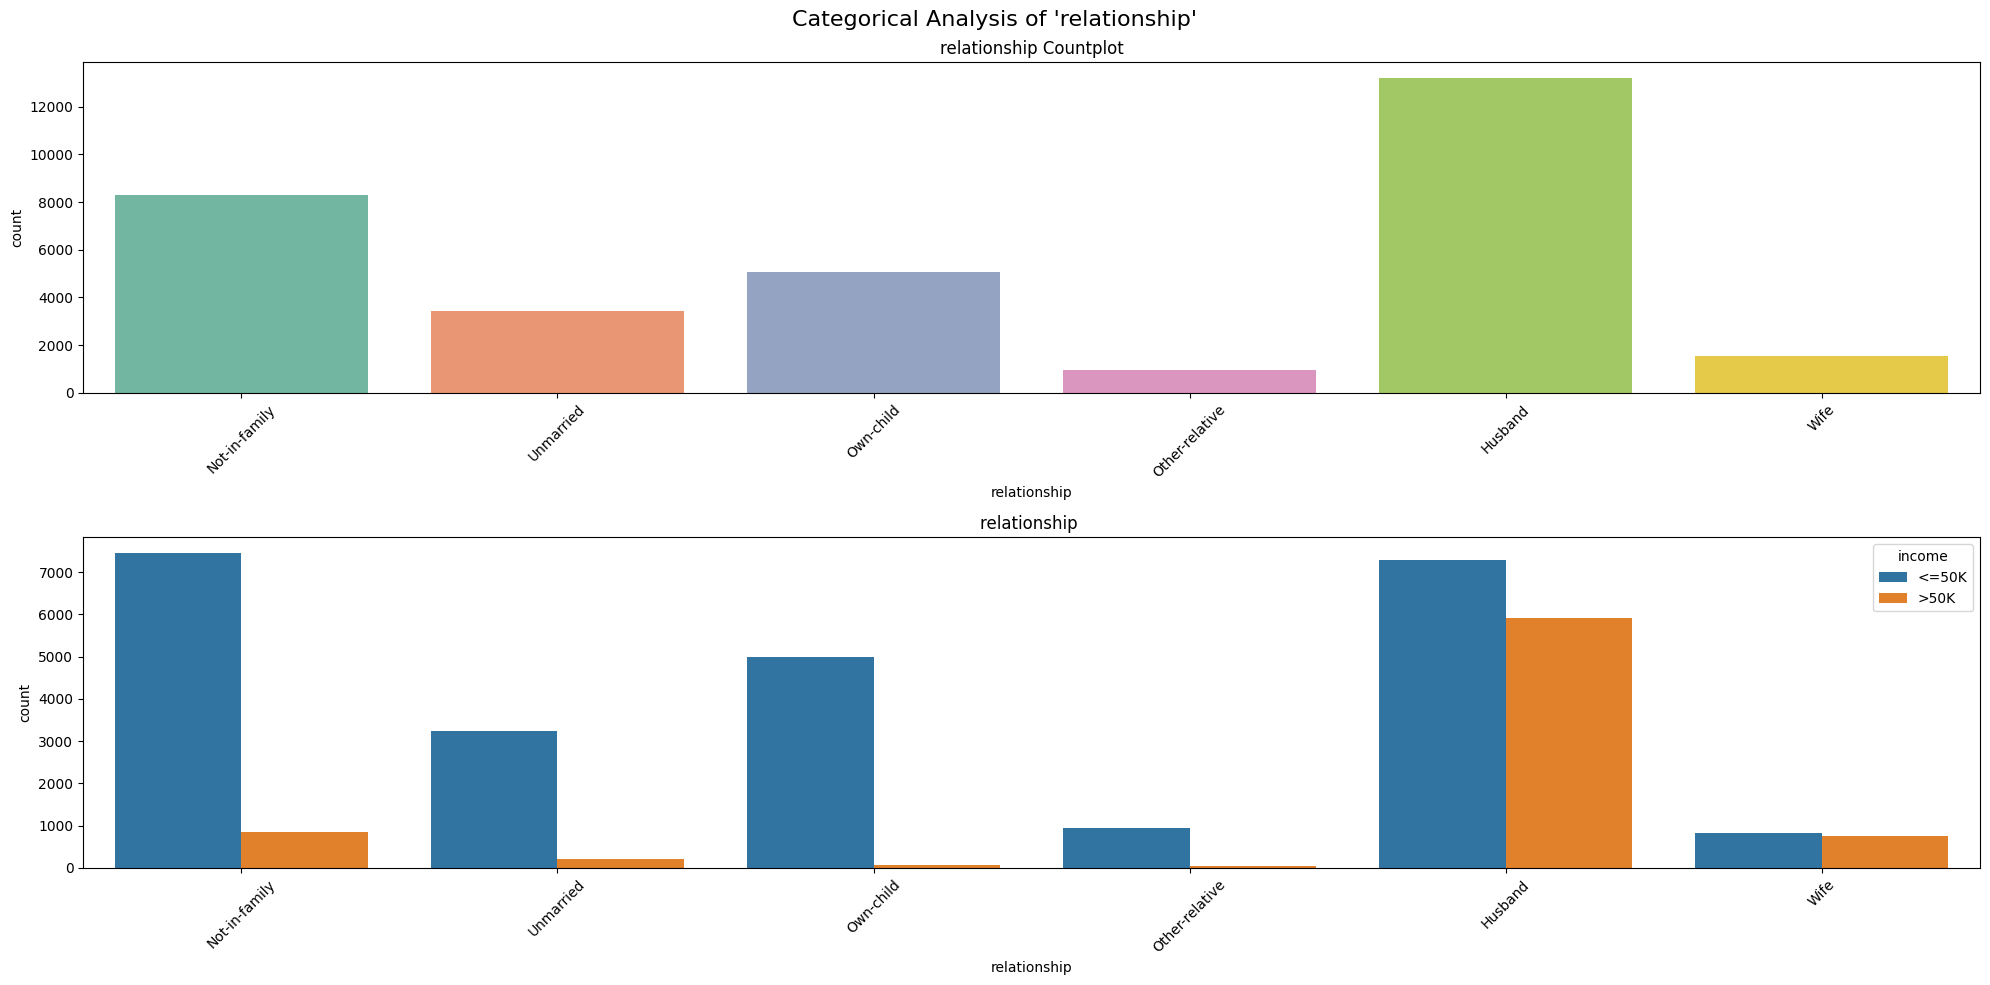

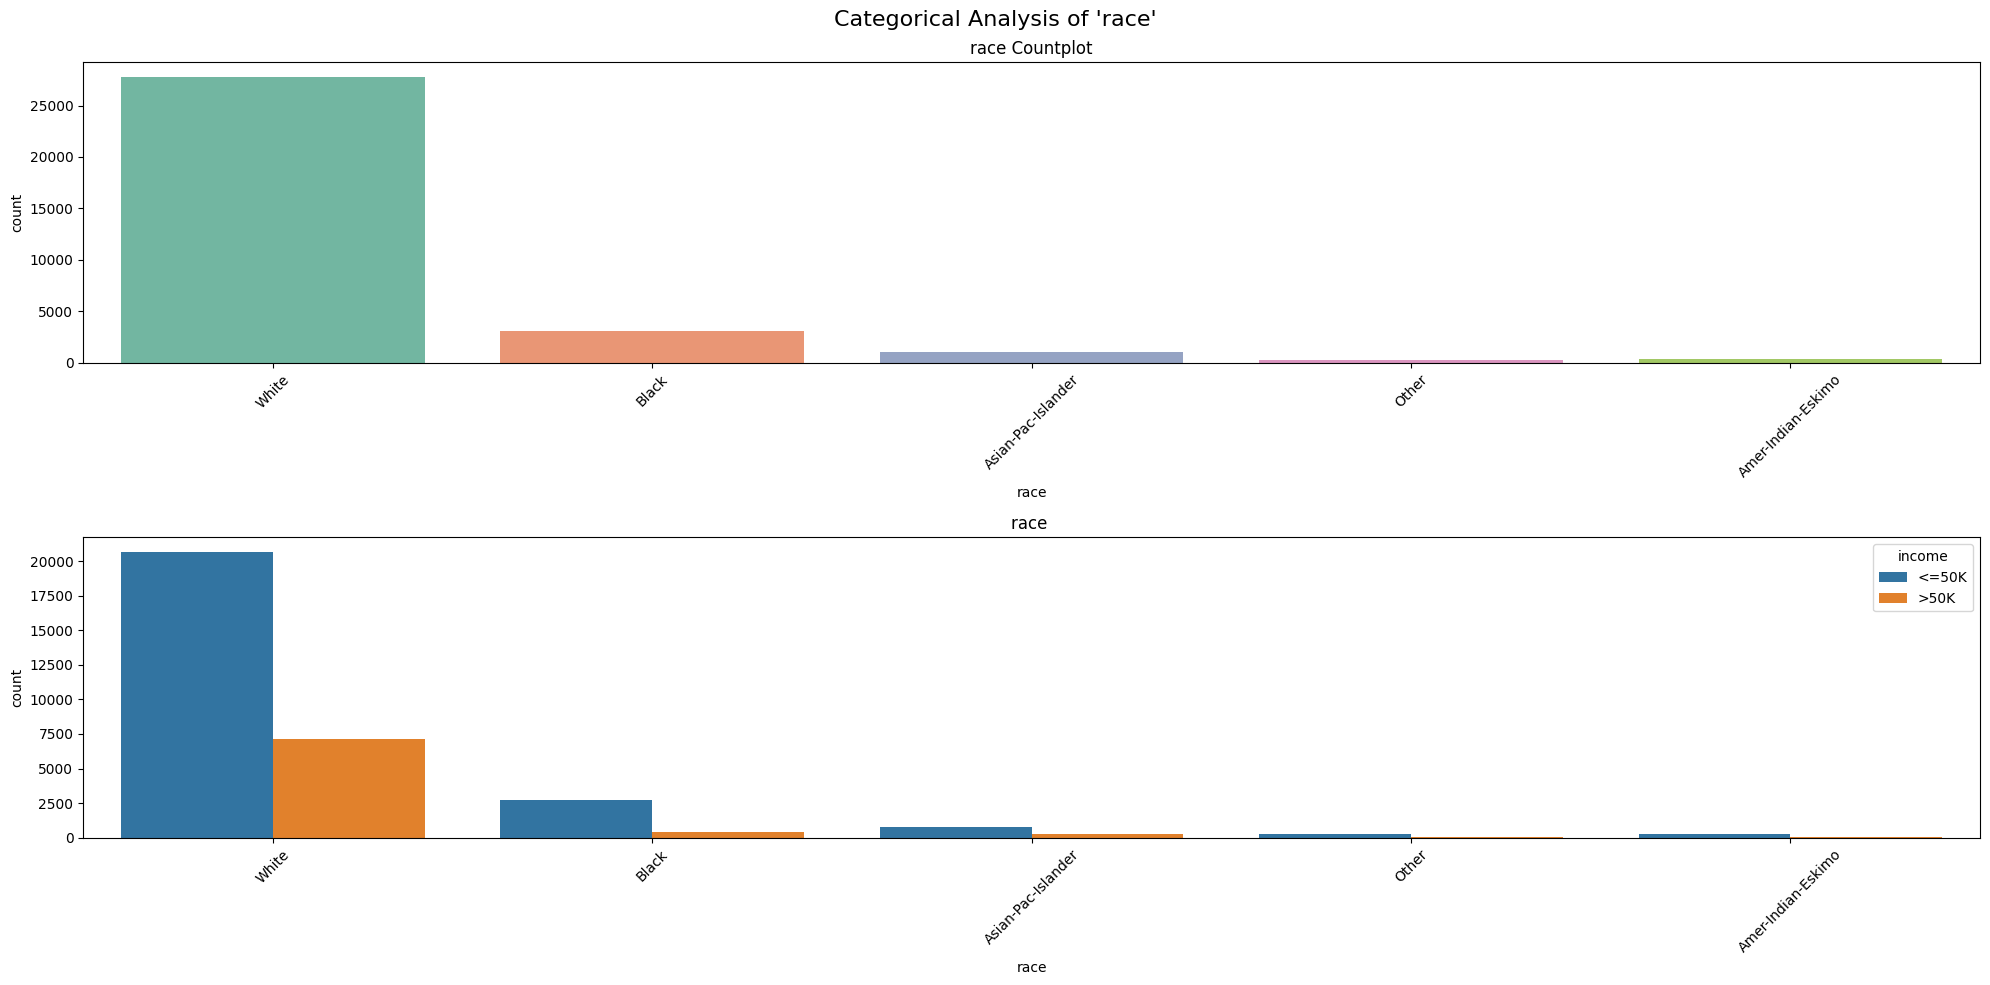

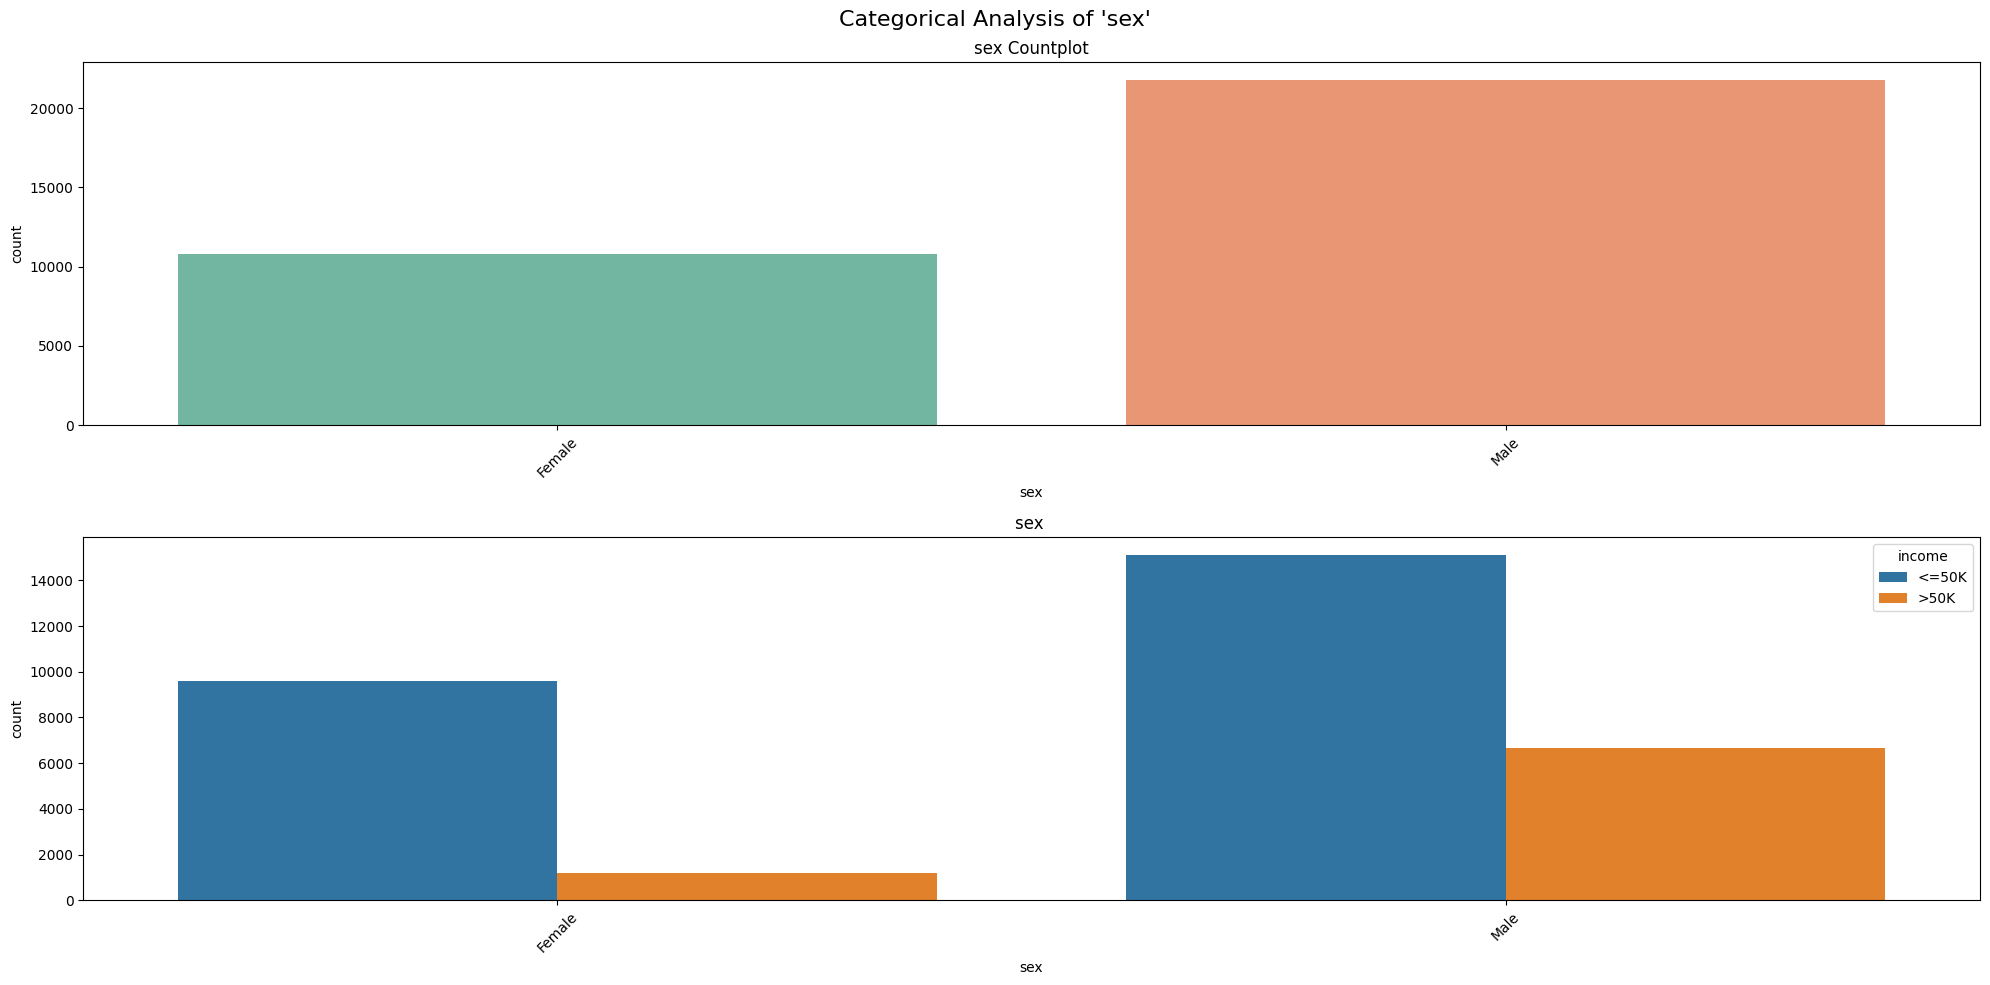

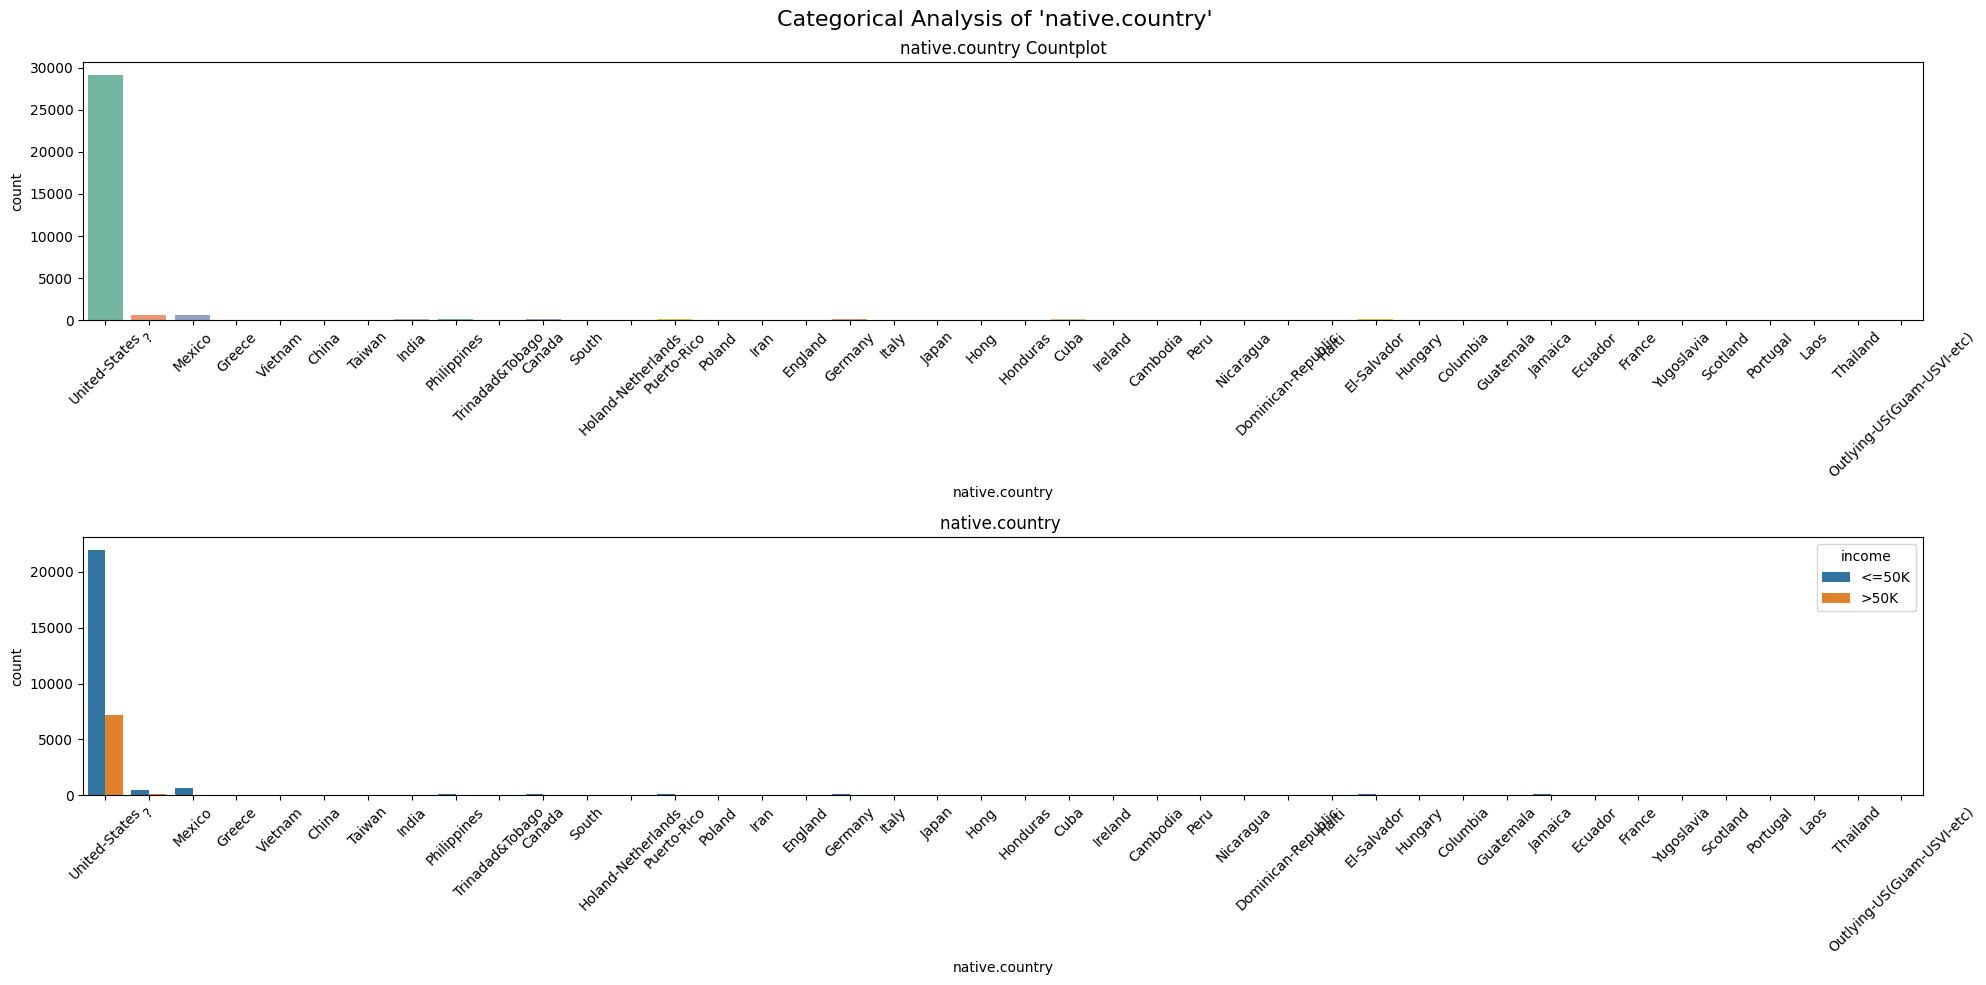

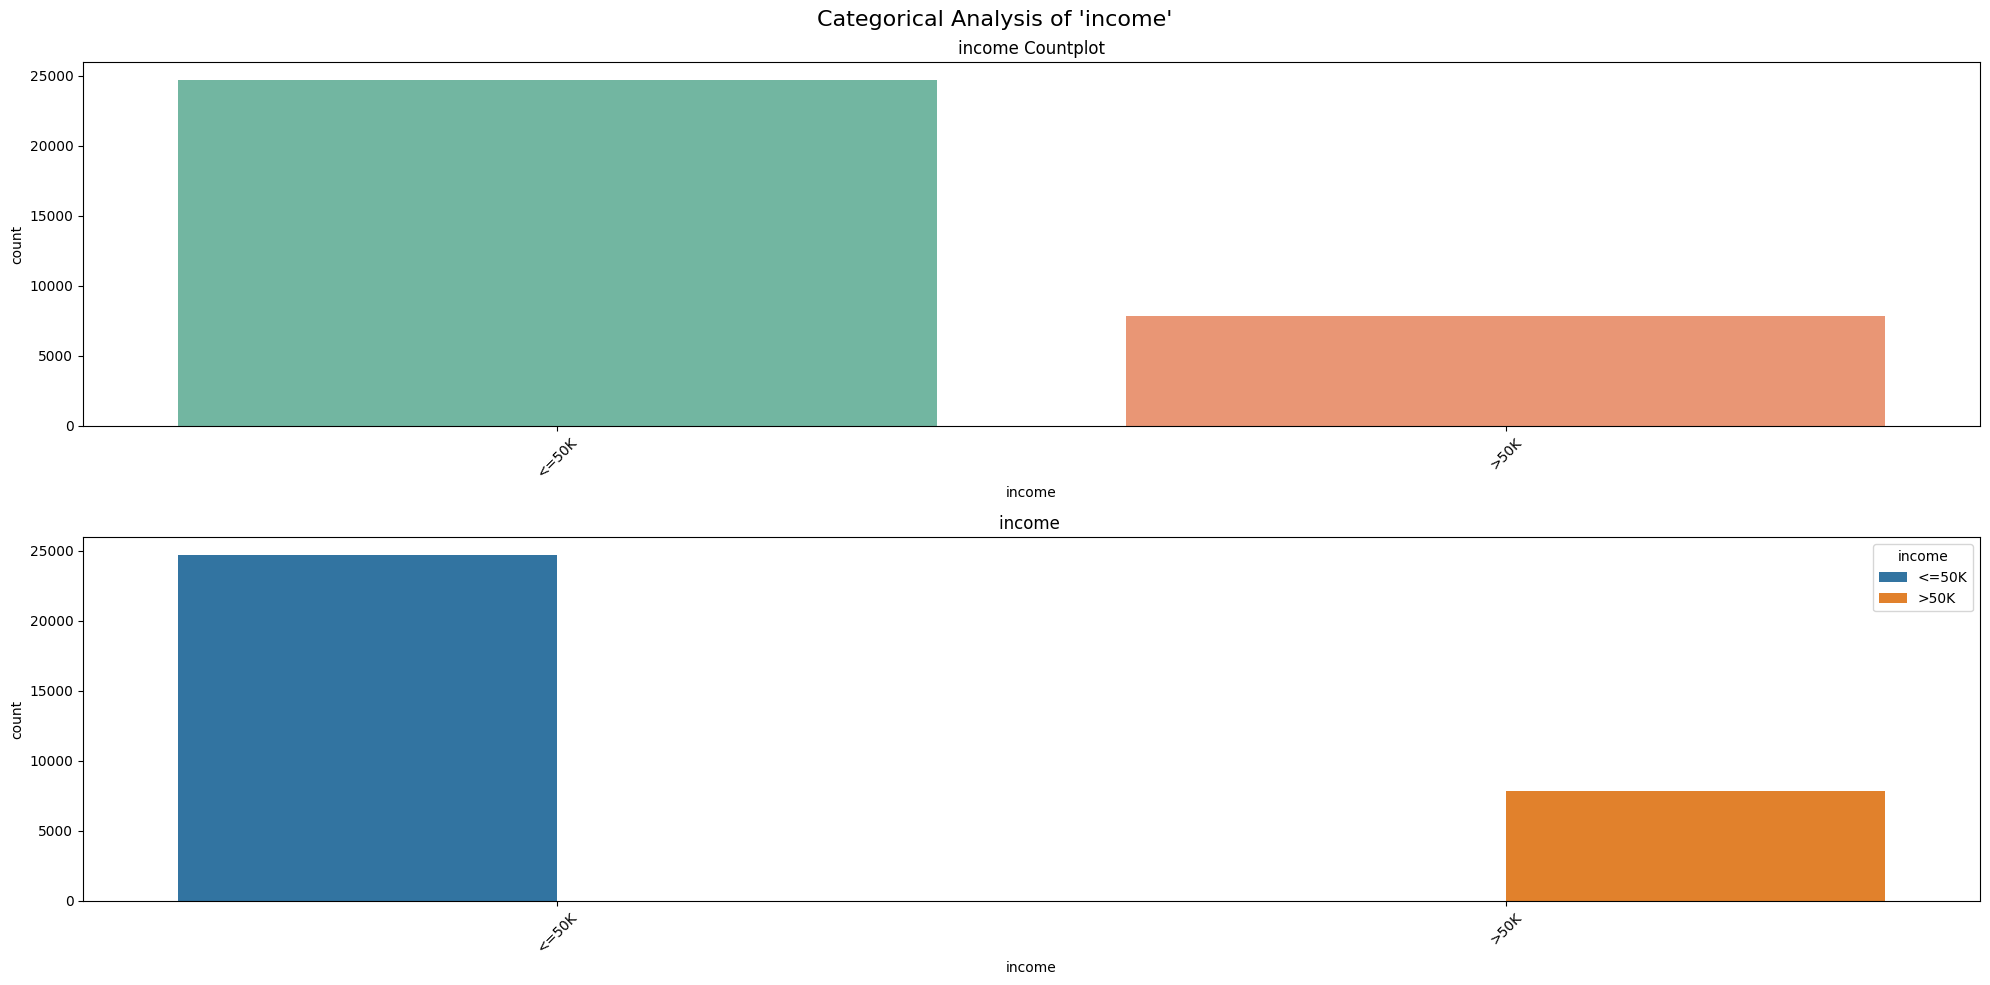

In [14]:
cat_col = df.select_dtypes(include=['object']).columns

for col in cat_col:
    fig, axes = plt.subplots(2, 1, figsize=(20, 10))   
    fig.suptitle(f"Categorical Analysis of '{col}'", fontsize=16)

    sns.countplot(x=col, data=df, ax=axes[0], palette='Set2')
    axes[0].set_title(f"{col} Countplot")
    axes[0].tick_params(axis='x', rotation=45)  

    sns.countplot(x=col, hue='income', data=df, ax=axes[1])
    axes[1].set_title(f"{col} ")
    axes[1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

In [15]:

print(df['native.country'].value_counts(dropna=False))
print("\nNumber of unique values:", df['native.country'].nunique(dropna=False))


native.country
United-States                 29170
Mexico                          643
?                               583
Philippines                     198
Germany                         137
Canada                          121
Puerto-Rico                     114
El-Salvador                     106
India                           100
Cuba                             95
England                          90
Jamaica                          81
South                            80
China                            75
Italy                            73
Dominican-Republic               70
Vietnam                          67
Guatemala                        64
Japan                            62
Poland                           60
Columbia                         59
Taiwan                           51
Haiti                            44
Iran                             43
Portugal                         37
Nicaragua                        34
Peru                             31
Greece       

In [16]:
question_mark_counts = (df == '?').sum()

cols_with_question_marks = question_mark_counts[question_mark_counts > 0]

print("Columns containing '?' and their counts:")
print(cols_with_question_marks)


Columns containing '?' and their counts:
workclass         1836
occupation        1843
native.country     583
dtype: int64


In [17]:
cols_with_question_mark = ['workclass', 'occupation', 'native.country']

for col in cols_with_question_mark:
    df[col] = df[col].replace('?', np.nan)


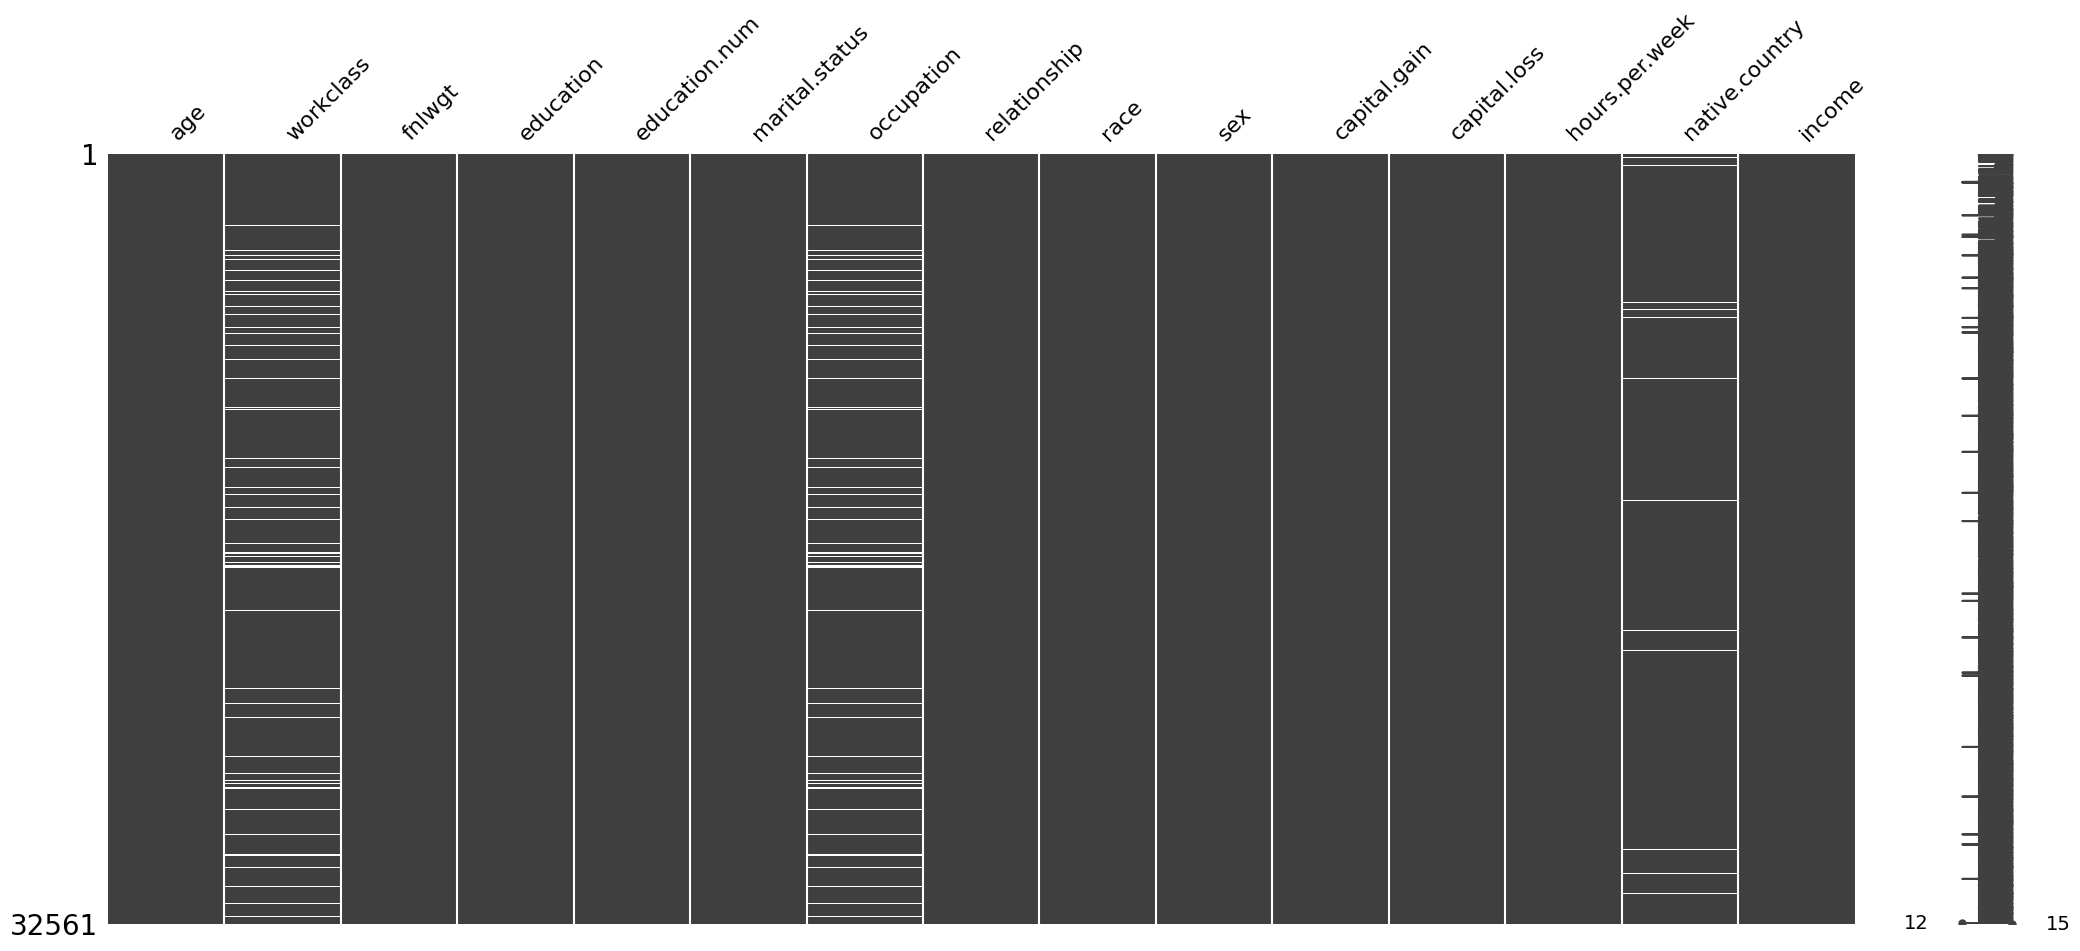

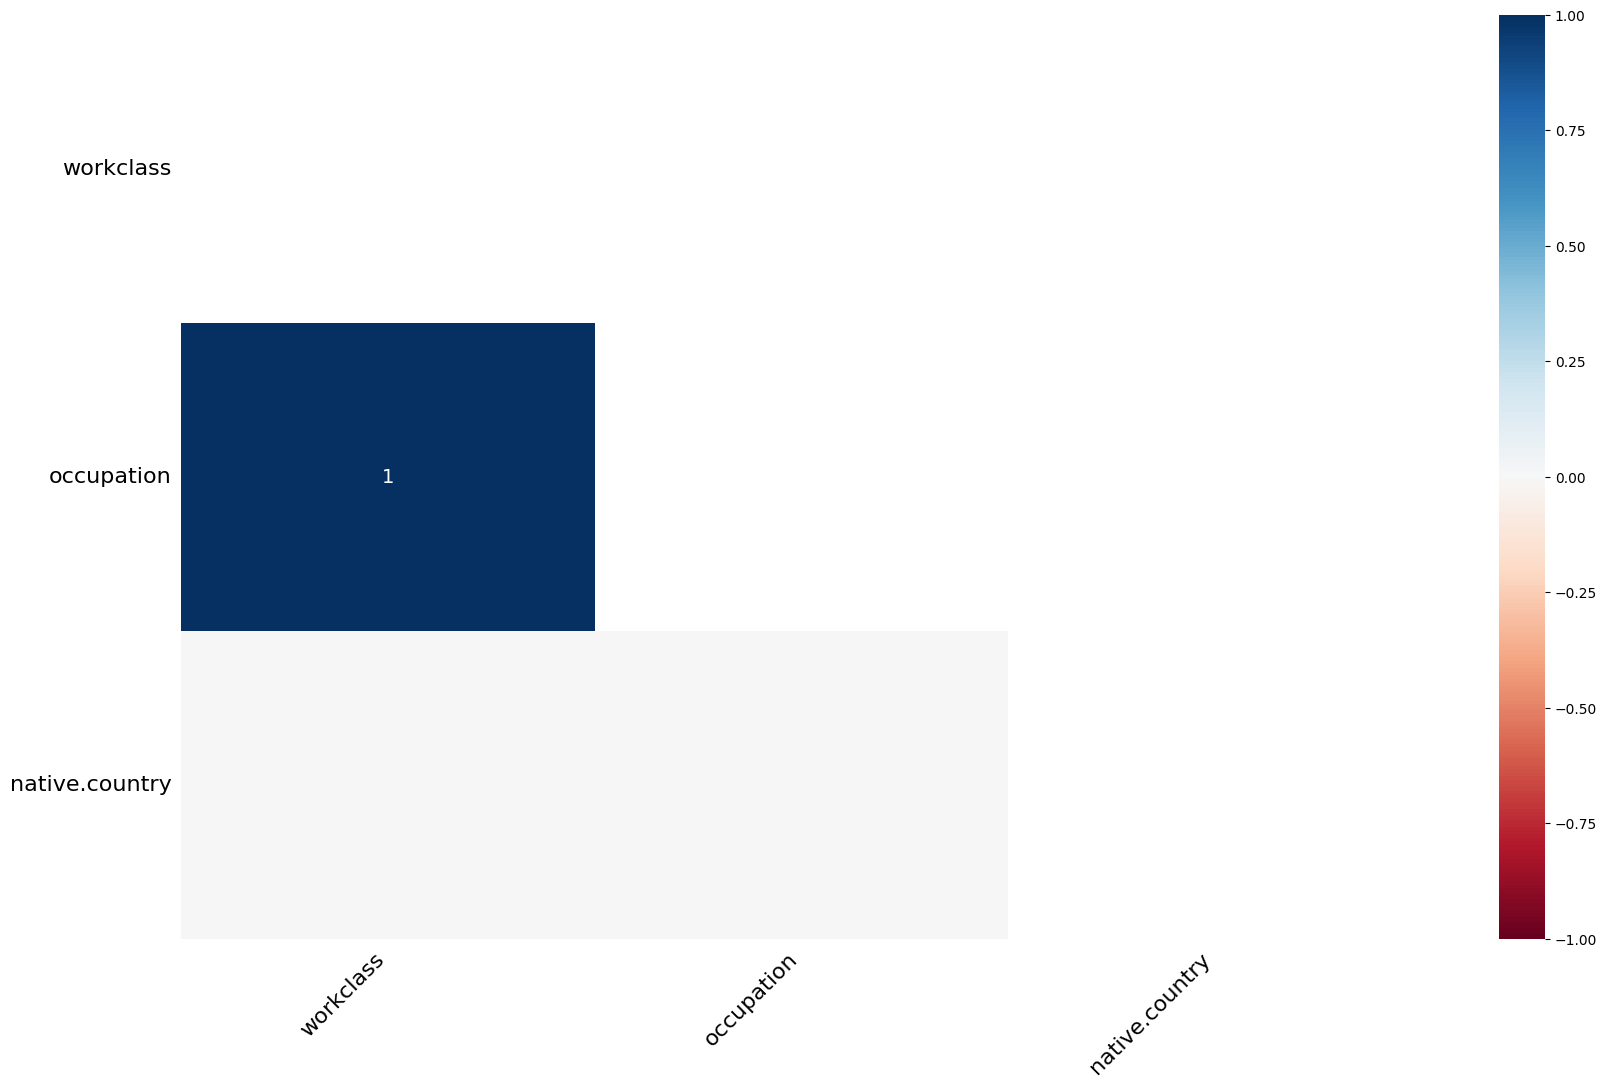

In [18]:
if df.isnull().sum().sum() > 0:
    import missingno as msno
    msno.matrix(df)
    msno.heatmap(df)
else:
    print("No missing values — skipping missingno plots.")


**Whenever occupation is missing, workclass is also missing (and vice versa).**

In [19]:
df[cols_with_question_mark].isnull().sum()


workclass         1836
occupation        1843
native.country     583
dtype: int64

In [20]:
df[df['occupation'].isnull() & df['workclass'].notnull()]


,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
8874,18,Never-worked,206359,10th,6,Never-married,NaN,Own-child,White,Male,0,0,40,United-States,<=50K
13675,23,Never-worked,188535,7th-8th,4,Divorced,NaN,Not-in-family,White,Male,0,0,35,United-States,<=50K
17089,17,Never-worked,237272,10th,6,Never-married,NaN,Own-child,White,Male,0,0,30,United-States,<=50K
21934,18,Never-worked,157131,11th,7,Never-married,NaN,Own-child,White,Female,0,0,10,United-States,<=50K
24483,20,Never-worked,462294,Some-college,10,Never-married,NaN,Own-child,Black,Male,0,0,40,United-States,<=50K
32331,30,Never-worked,176673,HS-grad,9,Married-civ-spouse,NaN,Wife,Black,Female,0,0,40,United-States,<=50K
32338,18,Never-worked,153663,Some-college,10,Never-married,NaN,Own-child,White,Male,0,0,4,United-States,<=50K


**Seems Different from my assumption as previous**

In [21]:
corr = df[cols_with_question_mark].isnull().astype(int).corr()
print(corr)


                workclass  occupation  native.country
workclass        1.000000    0.997985       -0.005897
occupation       0.997985    1.000000       -0.006012
native.country  -0.005897   -0.006012        1.000000


### **Key Insights:**

**workclass and occupation:**

Correlation ≈ 0.998 → very strong missingness relationship

They are almost always missing together

But not perfectly (as I saw 8 exceptions)

**native.country:**

Correlation ≈ 0 with the others

Missing independently

Should be treated as separate in imputation strategy

## Target Mean Plot

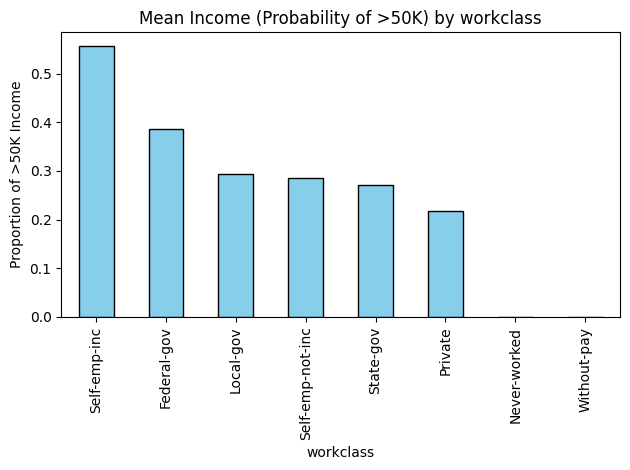

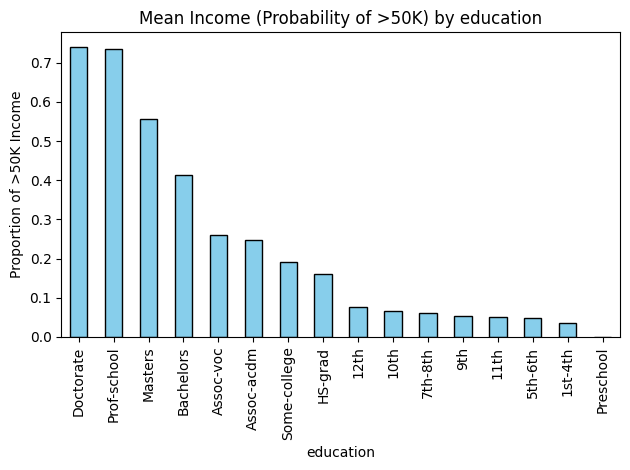

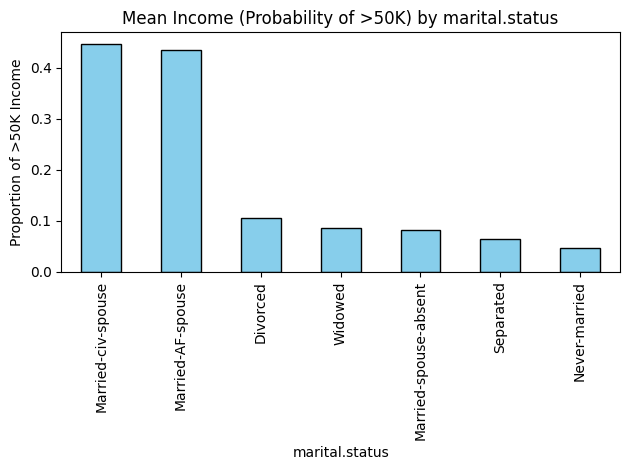

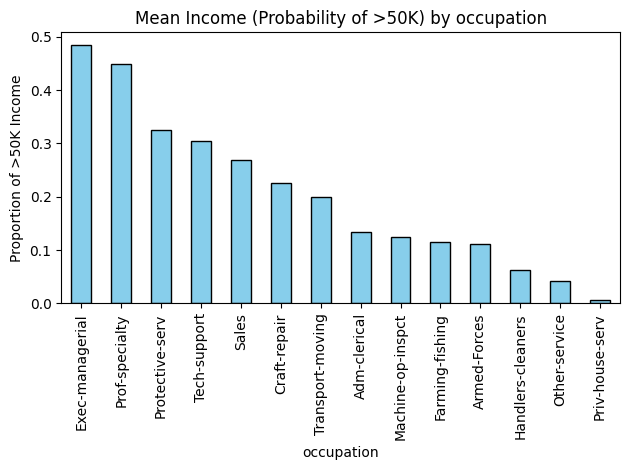

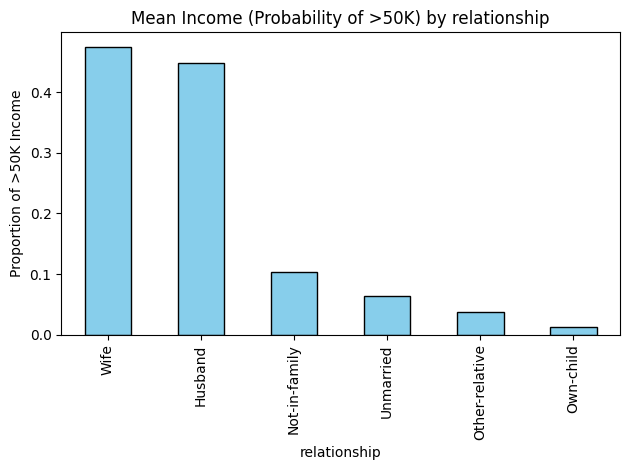

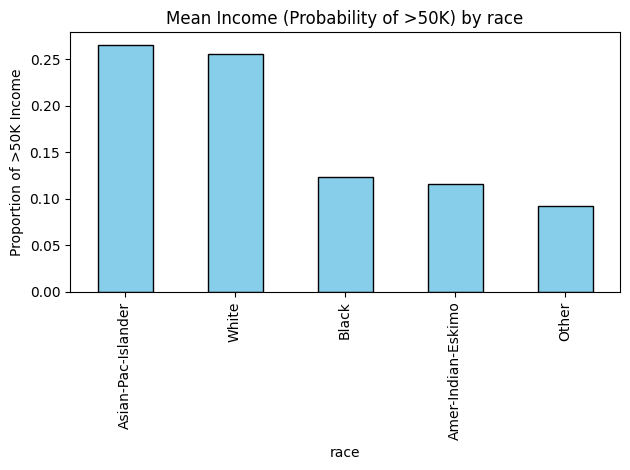

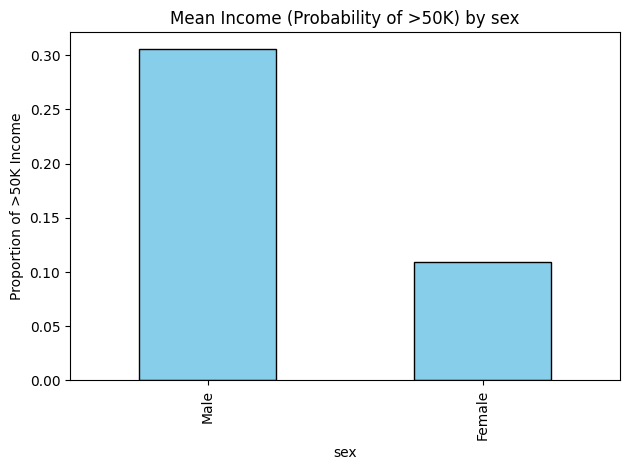

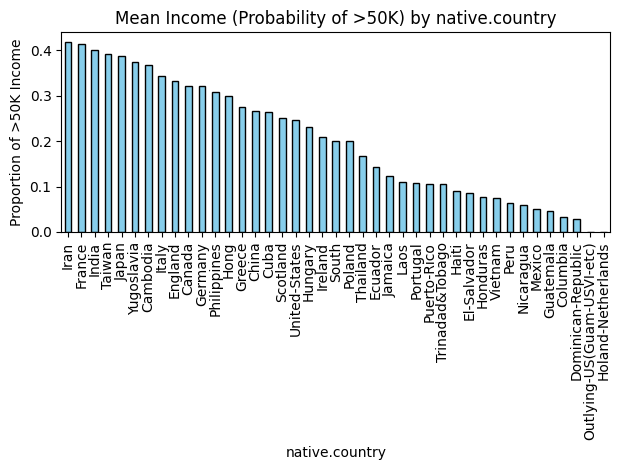

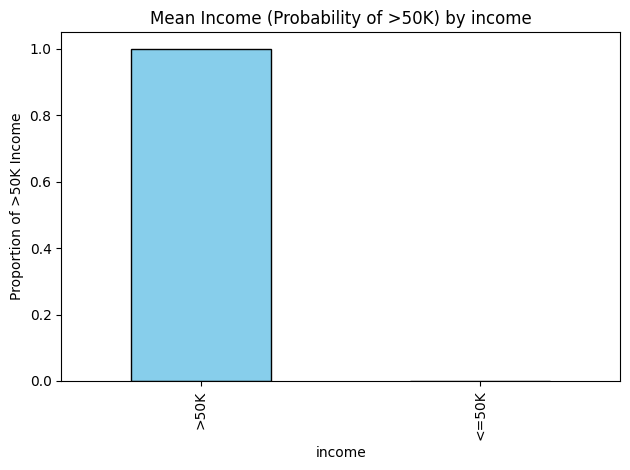

In [22]:
df['income_binary'] = df['income'].map({'<=50K': 0, '>50K': 1})

for col in cat_col:
    target_mean = df.groupby(col)['income_binary'].mean().sort_values(ascending=False)

    plt.Figure(figsize = (14, 8))
    target_mean.plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title(f'Mean Income (Probability of >50K) by {col}')
    plt.ylabel('Proportion of >50K Income')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

In [23]:
corr = df[num_cols.tolist() + ['income_binary']].corr()['income_binary'].sort_values(ascending=False)
print("correlation \n\n",corr)


correlation 

 income_binary     1.000000
education.num     0.335154
age               0.234037
hours.per.week    0.229689
capital.gain      0.223329
capital.loss      0.150526
fnlwgt           -0.009463
Name: income_binary, dtype: float64


## Numerical Feature Differences

In [24]:
from scipy.stats import ttest_ind
for col in num_cols:
    col0 = df[df['income_binary']== 0 ][col]
    col1 = df[df['income_binary']== 1 ][col]
    stat, p = ttest_ind(col0, col1)
    print(f"{col} | p-values: {p}")

age | p-values: 0.0
fnlwgt | p-values: 0.08773666108063947
education.num | p-values: 0.0
capital.gain | p-values: 0.0
capital.loss | p-values: 2.6865471890579053e-164
hours.per.week | p-values: 0.0


## Variance Inflation Factor

In [25]:
# VIF

from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

X_vif = df[num_cols]
vif_df = pd.DataFrame({
    'Feature':X_vif.columns,
    'VIF': [vif(X_vif.values, i) for i in range(X_vif.shape[1])]    
})
print(vif_df)

          Feature        VIF
0             age   7.246475
1          fnlwgt   3.683144
2   education.num  10.983289
3    capital.gain   1.032987
4    capital.loss   1.056815
5  hours.per.week   9.758094


**Education has vif more than 10, so it could be risky and age more than 7**

## Correlation

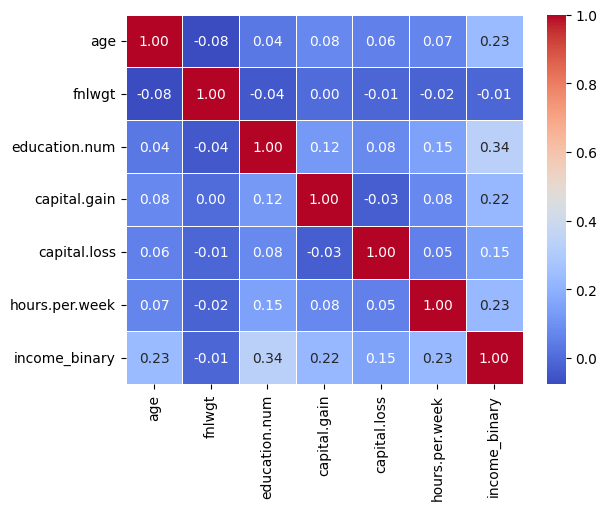

In [26]:
# Correlation
corr = df[num_cols.tolist() + ['income_binary']].corr()
sns.heatmap(corr, annot = True, cmap = 'coolwarm', fmt = '.2f', linewidth = 0.5)
plt.show()

In [27]:
demo = df[['education', 'education.num']].drop_duplicates().sort_values('education.num')
print(demo)


         education  education.num
1106     Preschool              1
26         1st-4th              2
27         5th-6th              3
3          7th-8th              4
197            9th              5
6             10th              6
16            11th              7
178           12th              8
0          HS-grad              9
2     Some-college             10
25       Assoc-voc             11
18      Assoc-acdm             12
12       Bachelors             13
13         Masters             14
11     Prof-school             15
7        Doctorate             16


In [28]:
# for tree-based models
df1 = df.copy()
df1.drop('education.num', axis=1, inplace=True)

# for linear models
df2 = df.copy()
df2.drop('education', axis=1, inplace=True)


# Train-Test Split

In [29]:
from sklearn.model_selection import train_test_split

# Tree-based  
X1 = df1.drop(['income', 'income_binary'], axis=1)
y1 = df1['income_binary']
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, 
random_state=42)

num_cols1 = X1_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols1 = X1_train.select_dtypes(include=['object']).columns.tolist()

# Linear model
X2 = df2.drop(['income', 'income_binary'], axis=1)
y2 = df2['income_binary']
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, 
random_state=42)

num_cols2 = X2_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols2 = X2_train.select_dtypes(include=['object']).columns.tolist()



# Outliers detection

In [30]:
from scipy.stats import zscore
import numpy as np

def handle_outliers(X_train, num_cols, dataset_name=""):
    print(f"--- Outlier handling for {dataset_name} ---\n")
    
    for col in num_cols:
        if col != 'income_binary':
            # Handle skewed features with IQR
            if abs(X_train[col].skew()) > 1:
                Q1, Q3 = X_train[col].quantile([0.25, 0.75])
                IQR = Q3 - Q1
                lower, upper = Q1 - 3*IQR, Q3 + 3*IQR
                outliers_b = X_train[(X_train[col] < lower) | (X_train[col] > upper)]
                X_train[col] = X_train[col].where((X_train[col] >= lower) & (X_train[col] <= upper))
                outliers_a = X_train[(X_train[col] < lower) | (X_train[col] > upper)]
            else:
                # Use z-score for less skewed data
                z_scores = zscore(X_train[col].dropna())
                outliers_b = X_train.loc[np.abs(z_scores) > 3]
                X_train[col] = X_train[col].where(np.abs(z_scores) <= 3)
                outliers_a = X_train.loc[np.abs(z_scores) > 3]

            print(f"{col}: {len(outliers_b)} outliers before")
            print(f"{col}: {len(outliers_a)} outliers after\n")

# for  tree-based training data
handle_outliers(X1_train, num_cols1, dataset_name="Tree-Based (X1_train)")

# for  linear-model training data
handle_outliers(X2_train, num_cols2, dataset_name="Linear Model (X2_train)")


--- Outlier handling for Tree-Based (X1_train) ---

age: 96 outliers before
age: 96 outliers after

fnlwgt: 109 outliers before
fnlwgt: 0 outliers after

capital.gain: 2179 outliers before
capital.gain: 0 outliers after

capital.loss: 1226 outliers before
capital.loss: 0 outliers after

hours.per.week: 357 outliers before
hours.per.week: 357 outliers after

--- Outlier handling for Linear Model (X2_train) ---

age: 96 outliers before
age: 96 outliers after

fnlwgt: 109 outliers before
fnlwgt: 0 outliers after

education.num: 172 outliers before
education.num: 172 outliers after

capital.gain: 2179 outliers before
capital.gain: 0 outliers after

capital.loss: 1226 outliers before
capital.loss: 0 outliers after

hours.per.week: 357 outliers before
hours.per.week: 357 outliers after



/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: Ru

# Model Pipeline

## Linear Model Pipeline

In [31]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

# For df2 (linear)
num_pipe_linear = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipe_linear = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor_linear = ColumnTransformer([
    ('num', num_pipe_linear, num_cols2),
    ('cat', cat_pipe_linear, cat_cols2)
])


## Tree-Based Model Pipeline

In [32]:
# For df1 (tree-based)
num_pipe_tree = Pipeline([
    ('imputer', SimpleImputer(strategy='median'))
])

cat_pipe_tree = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

preprocessor_tree = ColumnTransformer([
    ('num', num_pipe_tree, num_cols1),
    ('cat', cat_pipe_tree, cat_cols1)
])


# Model Fitting

In [33]:
import os
import joblib

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

models = {
    'RandomForest': RandomForestClassifier(random_state=42),
    'LogisticRegression': LogisticRegression(random_state=42, max_iter=1000),
    'KNN': KNeighborsClassifier(),
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'NaiveBayes': GaussianNB(),
    'LinearSVC': LinearSVC(random_state=42, max_iter=10000),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'LightGBM': LGBMClassifier(random_state=42),
    'CatBoost': CatBoostClassifier(verbose=0, random_state=42)
}

save_dir = "/kaggle/working/base_models"
os.makedirs(save_dir, exist_ok=True)

# Train and save each model
for name, model in models.items():
    try:
        print(f"Training {name}...")

        # Determine pipeline type
        if name in ['LogisticRegression', 'LinearSVC', 'KNN', 'NaiveBayes']:
            X_train, y_train = X2_train, y2_train
            preprocessor = preprocessor_linear
        else:
            X_train, y_train = X1_train, y1_train
            preprocessor = preprocessor_tree

        # Build pipeline
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', model)
        ])

        pipeline.fit(X_train, y_train)
        model_path = os.path.join(save_dir, f"{name}.joblib")
        joblib.dump(pipeline, model_path)

        print(f"{name} saved successfully to {model_path}\n")

    except Exception as e:
        print(f" Failed to train {name}: {e}\n")

# Save test sets once
joblib.dump(X1_test, "X1_test.joblib")
joblib.dump(y1_test, "y1_test.joblib")
joblib.dump(X2_test, "X2_test.joblib")
joblib.dump(y2_test, "y2_test.joblib")

print(f"Models saved to: {save_dir}")
print("Files in save_dir:", os.listdir(save_dir))


Training RandomForest...
RandomForest saved successfully to /kaggle/working/base_models/RandomForest.joblib

Training LogisticRegression...
LogisticRegression saved successfully to /kaggle/working/base_models/LogisticRegression.joblib

Training KNN...
KNN saved successfully to /kaggle/working/base_models/KNN.joblib

Training DecisionTree...
DecisionTree saved successfully to /kaggle/working/base_models/DecisionTree.joblib

Training NaiveBayes...
 Failed to train NaiveBayes: A sparse matrix was passed, but dense data is required. Use X.toarray() to convert to a dense numpy array.

Training LinearSVC...
LinearSVC saved successfully to /kaggle/working/base_models/LinearSVC.joblib

Training XGBoost...
XGBoost saved successfully to /kaggle/working/base_models/XGBoost.joblib

Training LightGBM...
[LightGBM] [Info] Number of positive: 6304, number of negative: 19744
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003433 seconds.
You can set `force_row_w

# Model Evalutation

Evaluating RandomForest.joblib ...
Accuracy:  0.8224
Precision: 0.6489
Recall:    0.5387
F1 Score:  0.5887


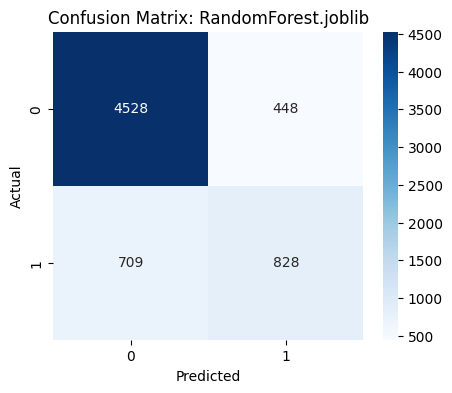

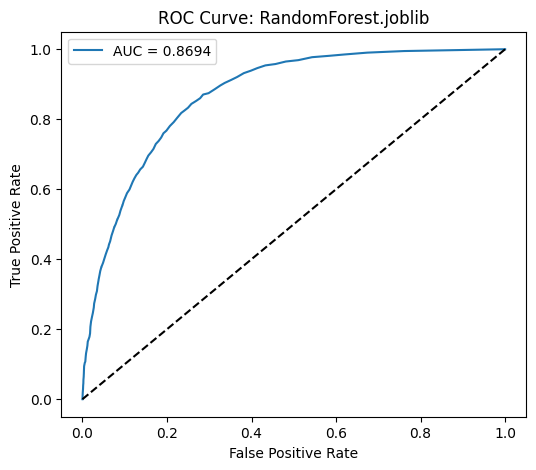



Evaluating LightGBM.joblib ...
Accuracy:  0.8386
Precision: 0.6941
Recall:    0.5654
F1 Score:  0.6232


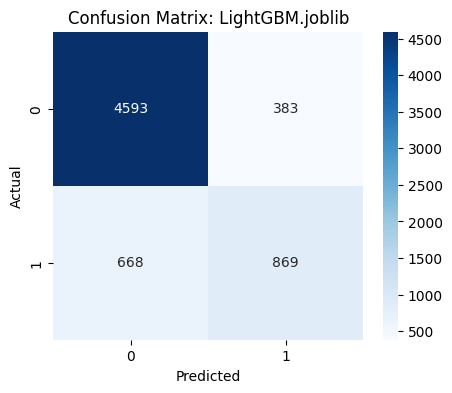

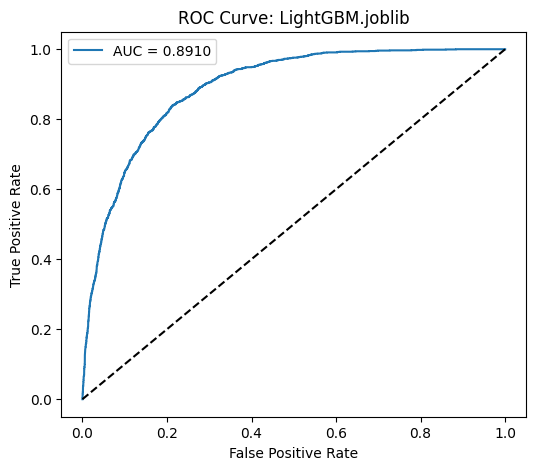



Evaluating CatBoost.joblib ...
Accuracy:  0.8397
Precision: 0.6974
Recall:    0.5667
F1 Score:  0.6253


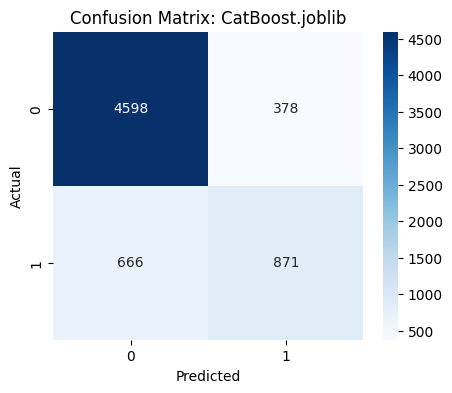

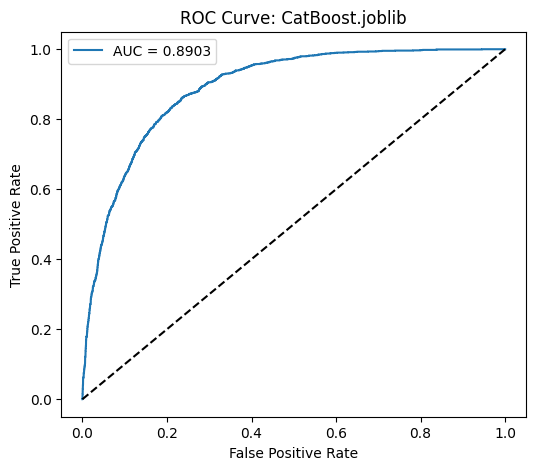



Evaluating LinearSVC.joblib ...
Accuracy:  0.8320
Precision: 0.6788
Recall:    0.5472
F1 Score:  0.6059


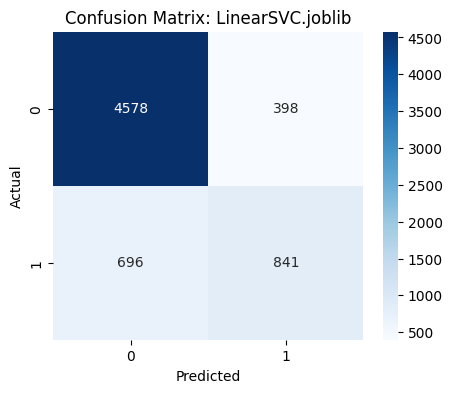

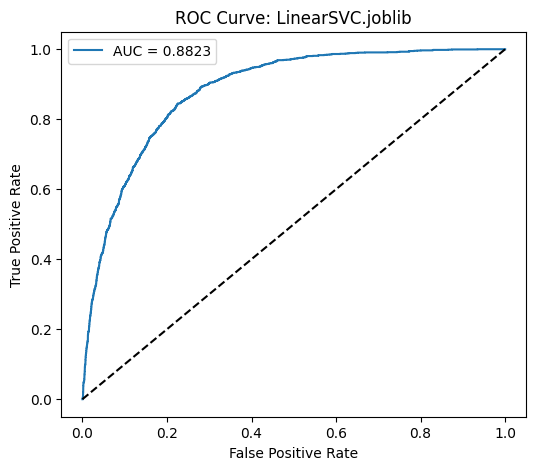



Evaluating KNN.joblib ...
Accuracy:  0.8262
Precision: 0.6473
Recall:    0.5791
F1 Score:  0.6113


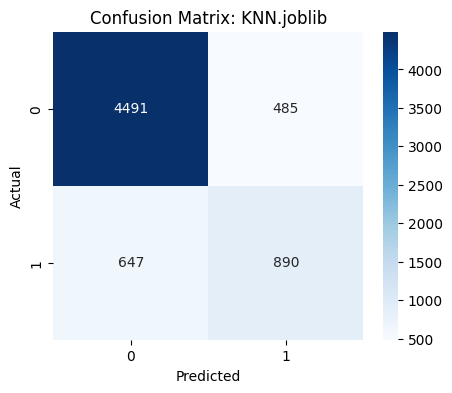

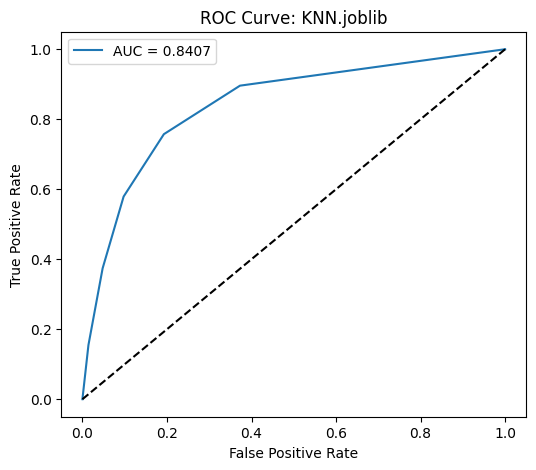



Evaluating LogisticRegression.joblib ...
Accuracy:  0.8336
Precision: 0.6816
Recall:    0.5530
F1 Score:  0.6106


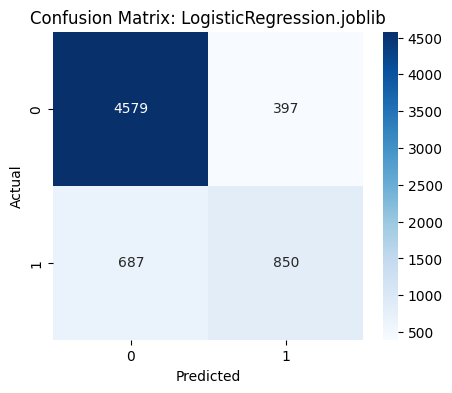

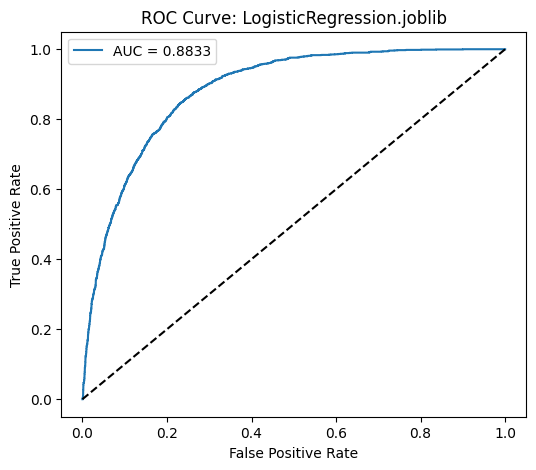



Evaluating XGBoost.joblib ...
Model XGBoost.joblib not assigned to a test set, skipping...

Evaluating DecisionTree.joblib ...
Accuracy:  0.7697
Precision: 0.5113
Recall:    0.5439
F1 Score:  0.5271


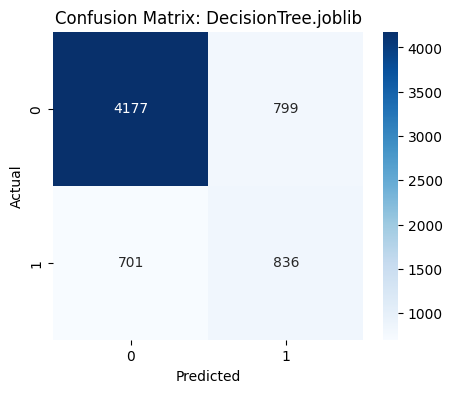

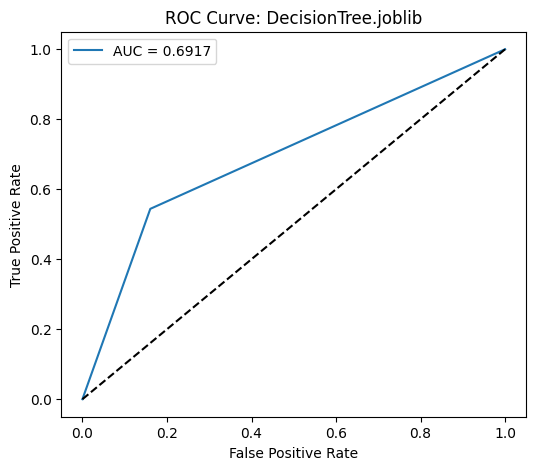

In [34]:
import os
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve

save_dir = "/kaggle/working/base_models"

# Load test sets
X1_test = joblib.load("X1_test.joblib")
y1_test = joblib.load("y1_test.joblib")

X2_test = joblib.load("X2_test.joblib")
y2_test = joblib.load("y2_test.joblib")

model_files = [f for f in os.listdir(save_dir) if f.endswith(".joblib")]


tree_based_models = ['RandomForest.joblib', 'DecisionTree.joblib', 'LightGBM.joblib', 'CatBoost.joblib']
linear_models = ['LogisticRegression.joblib', 'LinearSVC.joblib', 'KNN.joblib']

for model_file in model_files:
    print(f"Evaluating {model_file} ...")
    pipeline = joblib.load(os.path.join(save_dir, model_file))

    # Choose the correct test data
    if model_file in tree_based_models:
        X_test, y_test = X1_test, y1_test
    elif model_file in linear_models:
        X_test, y_test = X2_test, y2_test
    else:
        print(f"Model {model_file} not assigned to a test set, skipping...\n")
        continue


     # Check if loaded object is Pipeline and has 'classifier' step
    if hasattr(pipeline, 'named_steps') and 'classifier' in pipeline.named_steps:
        classifier = pipeline.named_steps['classifier']
        y_pred = pipeline.predict(X_test)
        # Get probabilities or decision function if available
        if hasattr(classifier, "predict_proba"):
            y_proba = pipeline.predict_proba(X_test)[:, 1]
        elif hasattr(classifier, "decision_function"):
            y_proba = pipeline.decision_function(X_test)
            from sklearn.preprocessing import MinMaxScaler
            scaler = MinMaxScaler()
            y_proba = scaler.fit_transform(y_proba.reshape(-1,1)).ravel()
        else:
            y_proba = None
    else:
        # Fallback: treat pipeline as model itself
        y_pred = pipeline.predict(X_test)
        if hasattr(pipeline, "predict_proba"):
            y_proba = pipeline.predict_proba(X_test)[:, 1]
        elif hasattr(pipeline, "decision_function"):
            y_proba = pipeline.decision_function(X_test)
            from sklearn.preprocessing import MinMaxScaler
            scaler = MinMaxScaler()
            y_proba = scaler.fit_transform(y_proba.reshape(-1,1)).ravel()
        else:
            y_proba = None
            
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1 Score:  {f1:.4f}")

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix: {model_file}")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # ROC AUC curve if possible
    if y_proba is not None:
        auc = roc_auc_score(y_test, y_proba)
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.figure(figsize=(6,5))
        plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
        plt.plot([0,1], [0,1], 'k--')
        plt.title(f'ROC Curve: {model_file}')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        plt.show()

    print("\n" + "="*50 + "\n")


# Learning Curve

Processing learning curve for RandomForest.joblib ...


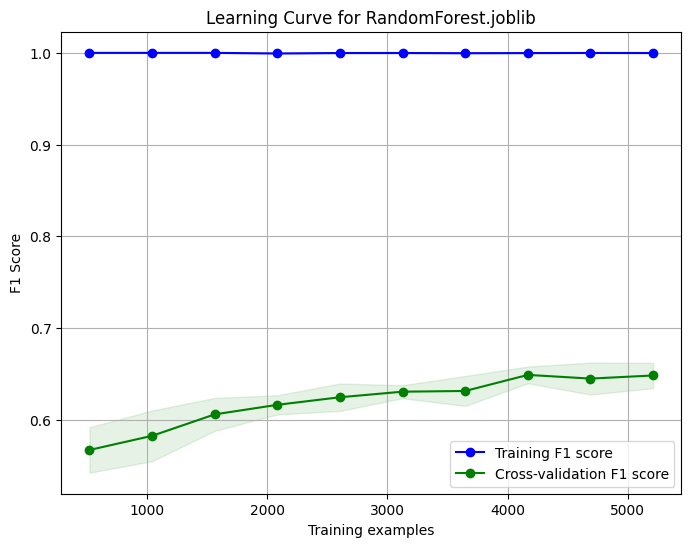

Processing learning curve for LightGBM.joblib ...
Skipping LightGBM.joblib as it doesn't match model groups.
Processing learning curve for CatBoost.joblib ...
Skipping CatBoost.joblib as it doesn't match model groups.
Processing learning curve for LinearSVC.joblib ...


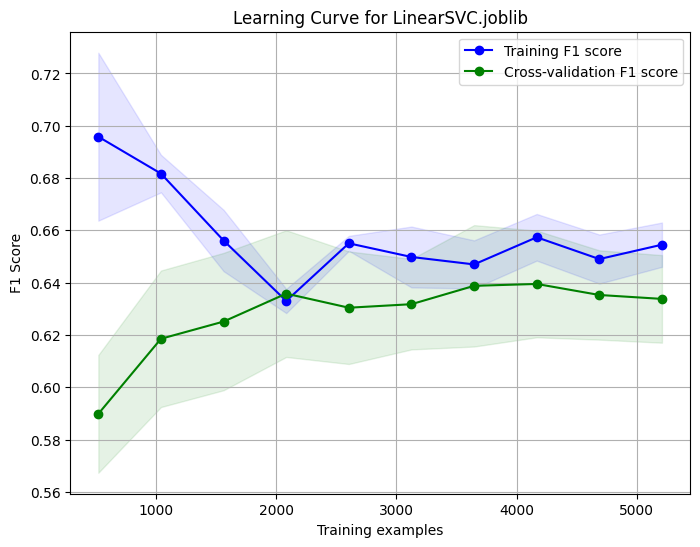

Processing learning curve for KNN.joblib ...


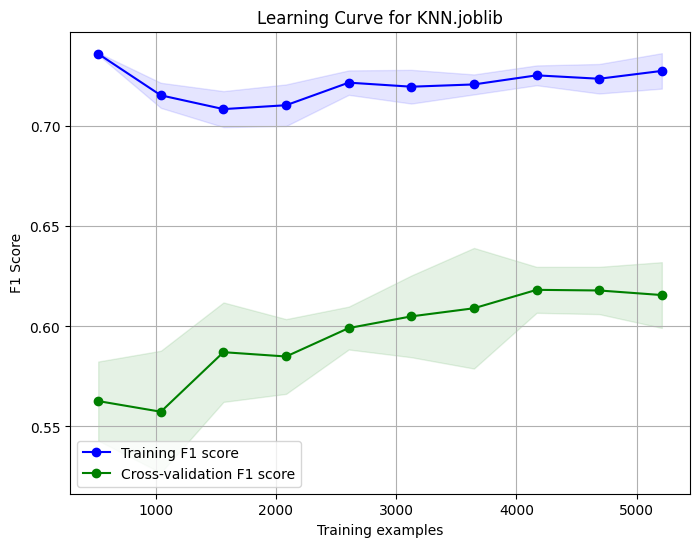

Processing learning curve for LogisticRegression.joblib ...


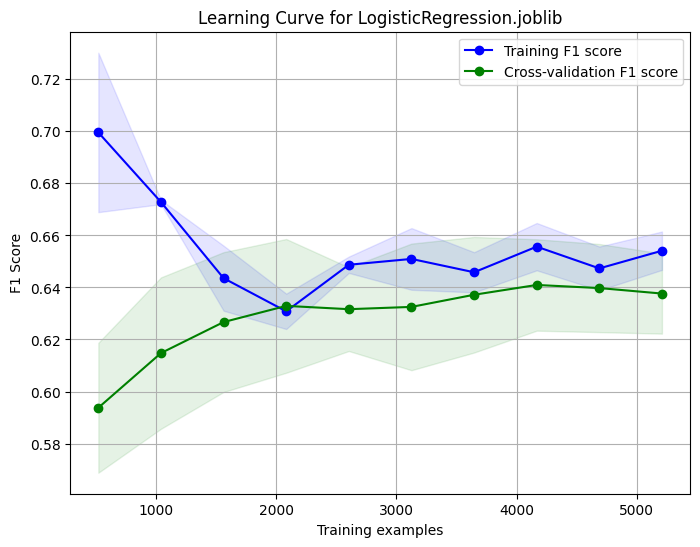

Processing learning curve for XGBoost.joblib ...
Skipping XGBoost.joblib as it doesn't match model groups.
Processing learning curve for DecisionTree.joblib ...


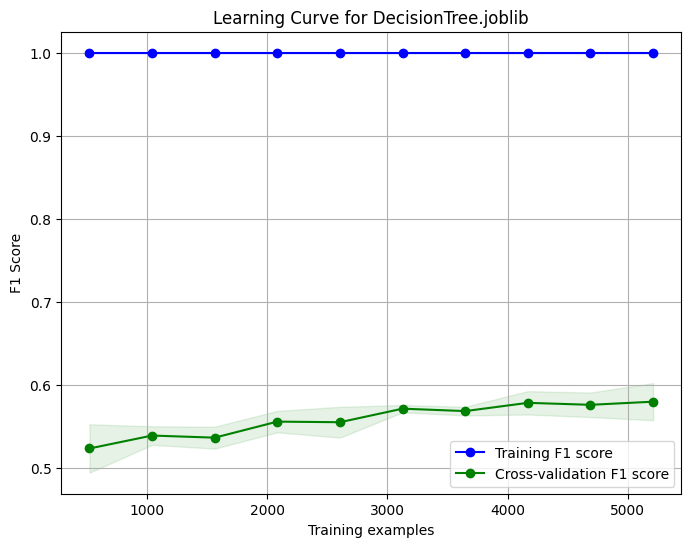

In [35]:
from sklearn.model_selection import learning_curve
from sklearn.metrics import make_scorer, f1_score


model_files = [f for f in os.listdir(save_dir) if f.endswith(".joblib")]

tree_based_models = ['RandomForest.joblib', 'DecisionTree.joblib']
linear_models = ['LogisticRegression.joblib', 'LinearSVC.joblib', 'KNN.joblib']

def plot_learning_curve(estimator, X, y, title):
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, X, y,
        cv=5,
        scoring=make_scorer(f1_score),
        n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10),
        verbose=0
    )

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    plt.figure(figsize=(8,6))
    plt.plot(train_sizes, train_mean, 'o-', color='blue', label="Training F1 score")
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')

    plt.plot(train_sizes, val_mean, 'o-', color='green', label="Cross-validation F1 score")
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='green')

    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("F1 Score")
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()

for model_file in model_files:
    print(f"Processing learning curve for {model_file} ...")
    pipeline = joblib.load(os.path.join(save_dir, model_file))

    # Select train data corresponding to model type
    if model_file in tree_based_models:
        X_train, y_train = X1_test, y1_test   
    elif model_file in linear_models:
        X_train, y_train = X2_test, y2_test
    else:
        print(f"Skipping {model_file} as it doesn't match model groups.")
        continue

    try:
        plot_learning_curve(pipeline, X_train, y_train, title=f"Learning Curve for {model_file}")
    except Exception as e:
        print(f"Failed to plot learning curve for {model_file}: {e}")
